In [11]:
from skopt import gp_minimize
from skopt import forest_minimize # Bayesian Optimization with RF as surrogate
from skopt import gbrt_minimize # Bayesian Optimization with GBM as surrogate
from skopt import Optimizer # for the optimization
from joblib import Parallel, delayed # for the parallelization
from skopt import dummy_minimize # for the randomized search
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
cv = KFold(n_splits=5, shuffle=True, random_state=1)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math

In [229]:
PC = pd.read_excel("PC.xlsx")
PC['P_PcS']=PC['P']/((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)/pi*1000.0
X=PC[['D', 't', 'L', 'Fy', 'fc']]
y=PC['P_PcS']
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=42)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
import xgboost as xgb

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        #"num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("booster", ['gbtree', 'dart']),#, 'rf'
    }
    model = xgb.XGBRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-01-10 15:28:00,986] A new study created in memory with name: no-name-dcc59825-1c84-49b7-a4e3-a8276a3a0f49
[I 2024-01-10 15:28:10,146] Trial 5 finished with value: 1.6227789411435523 and parameters: {'n_estimators': 628, 'learning_rate': 0.003369367718893696, 'gamma': 36.08073081160001, 'max_depth': 3, 'booster': 'dart'}. Best is trial 5 with value: 1.6227789411435523.
[I 2024-01-10 15:28:12,586] Trial 0 finished with value: 3.6558597753232354 and parameters: {'n_estimators': 35, 'learning_rate': 0.02309691213027222, 'gamma': 0.026617097829753723, 'max_depth': 22, 'booster': 'dart'}. Best is trial 5 with value: 1.6227789411435523.
[I 2024-01-10 15:28:13,711] Trial 6 finished with value: 5.333333713597123 and parameters: {'n_estimators': 73, 'learning_rate': 0.005213673613216811, 'gamma': 6.684326694743577, 'max_depth': 19, 'booster': 'gbtree'}. Best is trial 5 with value: 1.6227789411435523.
[I 2024-01-10 15:28:14,234] Trial 8 finished with value: 2.198240099486798 and parameter

Best hyperparameters: {'n_estimators': 217, 'learning_rate': 0.006724270507470383, 'gamma': 22.856166676395556, 'max_depth': 2, 'booster': 'gbtree'}
Best RMSE: 1.0652937927852764


In [230]:
aa=xgb.XGBRegressor(random_state=1000,n_estimators=1144, max_depth=39, learning_rate=0.001439009594132477, booster='dart', gamma=16.462206470532227)
aa=xgb.XGBRegressor(n_estimators=217, max_depth=2, learning_rate=0.006724270507470383, booster='gbtree', gamma=22.856166676395556)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename = 'XGB_Circ.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

1.0631210132608362
Data exported to XGB_Circ.xlsx


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from lightgbm.sklearn import LGBMRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        #"gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 16, 50),
        "num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt', 'dart']),#, 'rf'
    }
    model = LGBMRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-01-10 15:34:15,645] A new study created in memory with name: no-name-7967da97-d5bc-4812-91b5-e33b1ebdf862
[I 2024-01-10 15:34:22,011] Trial 0 finished with value: 1.4914697369263306 and parameters: {'n_estimators': 125, 'learning_rate': 0.0019023329433493286, 'max_depth': 35, 'num_leaves': 17, 'boosting_type': 'dart'}. Best is trial 0 with value: 1.4914697369263306.
[I 2024-01-10 15:34:28,301] Trial 2 finished with value: 1.6222916327245744 and parameters: {'n_estimators': 853, 'learning_rate': 0.0846756285413242, 'max_depth': 47, 'num_leaves': 12, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 1.4914697369263306.
[I 2024-01-10 15:35:21,017] Trial 1 finished with value: 1.4325759036109549 and parameters: {'n_estimators': 1776, 'learning_rate': 0.003602578698558006, 'max_depth': 48, 'num_leaves': 16, 'boosting_type': 'dart'}. Best is trial 1 with value: 1.4325759036109549.
[I 2024-01-10 15:35:24,117] Trial 4 finished with value: 1.2043546451318436 and parameters: {'n_esti

Best hyperparameters: {'n_estimators': 1193, 'learning_rate': 0.0010052096373267558, 'max_depth': 50, 'num_leaves': 21, 'boosting_type': 'dart'}
Best RMSE: 1.119308451907034


In [135]:
aa=LGBMRegressor(n_estimators=1193,learning_rate=0.0010052096373267558, max_depth=50, num_leaves=21, boosting_type='dart')
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename = 'LGBM_circ.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 539, number of used features: 5
[LightGBM] [Info] Start training from score -0.135005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [121]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        #"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 50),
        "max_features": trial.suggest_categorical("max_features", ['sqrt','log2']),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),        
    }
    model = RandomForestRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-01-10 19:20:58,928] A new study created in memory with name: no-name-781fe23f-ea41-4d76-8a1b-76a680d64ffb
[I 2024-01-10 19:21:06,664] Trial 5 finished with value: 1.991284986645724 and parameters: {'n_estimators': 297, 'max_depth': 3, 'min_samples_leaf': 20, 'max_features': 'log2', 'bootstrap': False}. Best is trial 5 with value: 1.991284986645724.
[I 2024-01-10 19:21:06,974] Trial 1 finished with value: 1.6819141927878865 and parameters: {'n_estimators': 1900, 'max_depth': 11, 'min_samples_leaf': 15, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 1.6819141927878865.
[I 2024-01-10 19:21:07,097] Trial 2 finished with value: 1.8737746866166005 and parameters: {'n_estimators': 1042, 'max_depth': 10, 'min_samples_leaf': 50, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 1.6819141927878865.
[I 2024-01-10 19:21:07,803] Trial 4 finished with value: 2.225976568431554 and parameters: {'n_estimators': 1892, 'max_depth': 1, 'min_samples_l

Best hyperparameters: {'n_estimators': 483, 'max_depth': 11, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': True}
Best RMSE: 1.490425792802243


In [139]:
aa=RandomForestRegressor(random_state=1000,n_estimators=483, max_depth=11, min_samples_leaf=11, max_features='sqrt', bootstrap=True)
print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename = 'RF_circ.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


1.432382654719263
Data exported to RF_circ.xlsx


In [34]:
import catboost as cb

def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-01-10 00:38:47,319] A new study created in memory with name: no-name-50de3dc4-ecce-4304-b95a-bd8ff3e6ddb5
[I 2024-01-10 00:38:49,992] Trial 1 finished with value: 2.3651966825598802 and parameters: {'iterations': 195, 'learning_rate': 0.024982880136865608, 'depth': 1, 'subsample': 0.516380227218763, 'colsample_bylevel': 0.4911493025165344, 'min_data_in_leaf': 36}. Best is trial 1 with value: 2.3651966825598802.
[I 2024-01-10 00:38:53,219] Trial 3 finished with value: 1.8399519532984763 and parameters: {'iterations': 499, 'learning_rate': 0.004602344701718432, 'depth': 4, 'subsample': 0.7820881198919171, 'colsample_bylevel': 0.680886982601021, 'min_data_in_leaf': 61}. Best is trial 3 with value: 1.8399519532984763.
[I 2024-01-10 00:38:59,627] Trial 0 finished with value: 1.3117444908571037 and parameters: {'iterations': 285, 'learning_rate': 0.03411439267480786, 'depth': 10, 'subsample': 0.6508784298842939, 'colsample_bylevel': 0.5415630294205088, 'min_data_in_leaf': 6}. Best is

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\osama\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 2319, in _fit
    self._train(
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 1723, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4645, in _catboost._CatBoost._train
  File "_catboost.pyx", line 4694, in _catboost._CatBoost._train
_catboost.CatBoostError: bad allocation


In [141]:
aa=cb.CatBoostRegressor(iterations=1135,learning_rate=0.09342109519812346,depth=15,subsample=0.4715732143809523,colsample_bylevel=0.9427303576347658,min_data_in_leaf= 48)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename = 'Cat_circ.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0:	learn: 0.3347185	total: 471ms	remaining: 8m 54s
1:	learn: 0.3207054	total: 802ms	remaining: 7m 34s
2:	learn: 0.3079101	total: 1.2s	remaining: 7m 32s
3:	learn: 0.2954500	total: 1.53s	remaining: 7m 12s
4:	learn: 0.2839083	total: 1.89s	remaining: 7m 7s
5:	learn: 0.2728189	total: 2.15s	remaining: 6m 45s
6:	learn: 0.2630782	total: 2.44s	remaining: 6m 33s
7:	learn: 0.2541155	total: 2.71s	remaining: 6m 21s
8:	learn: 0.2449880	total: 2.77s	remaining: 5m 47s
9:	learn: 0.2364290	total: 3.09s	remaining: 5m 47s
10:	learn: 0.2283480	total: 3.39s	remaining: 5m 46s
11:	learn: 0.2213877	total: 3.67s	remaining: 5m 43s
12:	learn: 0.2147014	total: 3.98s	remaining: 5m 43s
13:	learn: 0.2081180	total: 4.23s	remaining: 5m 39s
14:	learn: 0.2020046	total: 4.48s	remaining: 5m 34s
15:	learn: 0.1959460	total: 4.61s	remaining: 5m 22s
16:	learn: 0.1901900	total: 4.87s	remaining: 5m 20s
17:	learn: 0.1853388	total: 4.91s	remaining: 5m 4s
18:	learn: 0.1800629	total: 5.19s	remaining: 5m 4s
19:	learn: 0.1754236	total

In [13]:
import catboost as cb
import optuna
import numpy as np
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.01, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-01-11 00:39:33,947] A new study created in memory with name: no-name-ffb76444-9924-4591-9b3b-2bf6563a8cbb
[I 2024-01-11 00:39:44,718] Trial 8 finished with value: 2.0074527428510427 and parameters: {'iterations': 1655, 'learning_rate': 0.0018384694193919796, 'depth': 3, 'subsample': 0.2771487131348017, 'colsample_bylevel': 0.47388529687020664, 'min_data_in_leaf': 89}. Best is trial 8 with value: 2.0074527428510427.
[I 2024-01-11 00:40:28,299] Trial 2 finished with value: 1.8193005489442442 and parameters: {'iterations': 1908, 'learning_rate': 0.0030705698704007194, 'depth': 3, 'subsample': 0.887117333435957, 'colsample_bylevel': 0.751243841786886, 'min_data_in_leaf': 39}. Best is trial 2 with value: 1.8193005489442442.
[I 2024-01-11 00:41:16,549] Trial 15 finished with value: 2.4092476480340133 and parameters: {'iterations': 536, 'learning_rate': 0.007832292666431923, 'depth': 1, 'subsample': 0.15181268227364886, 'colsample_bylevel': 0.7281927083006704, 'min_data_in_leaf': 32}.

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


: 

In [ ]:
aa=cb.CatBoostRegressor(iterations=1135,learning_rate=0.09342109519812346,depth=15,subsample=0.4715732143809523,colsample_bylevel=0.9427303576347658,min_data_in_leaf= 48)
print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

In [ ]:
aa=cb.CatBoostRegressor(iterations=1135,learning_rate=0.09342109519812346,depth=15,subsample=0.4715732143809523,colsample_bylevel=0.9427303576347658,min_data_in_leaf= 48)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

In [231]:
PC  = pd.read_excel("PR.xlsx")#['P', 'EC4', 'FE', 'ref', 'Author ', 'Year', 'L', 'H', 'B', 't', 'Fy', 'fc', 'D/B', 'L/B', 'D/t']
PC['P_PcS']=PC['P']/((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))*1000.0
X=PC[['H', 'B', 't', 'L', 'Fy', 'fc']]#PC.drop('P',axis=1)
y=PC['P_PcS']
X,y = np.array(X.values),np.array(y.values)
scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=101)

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
import xgboost as xgb

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        #"num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("booster", ['gbtree', 'dart']),#, 'rf'
    }
    model = xgb.XGBRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-01-10 17:16:45,196] A new study created in memory with name: no-name-a6696611-a8d7-4101-9f8d-03db82b1cd9c


[I 2024-01-10 17:16:52,485] Trial 2 finished with value: 1.3892077618771181 and parameters: {'n_estimators': 643, 'learning_rate': 0.12523135128271443, 'gamma': 1.7337867343199698, 'max_depth': 11, 'booster': 'gbtree'}. Best is trial 2 with value: 1.3892077618771181.
[I 2024-01-10 17:16:54,427] Trial 0 finished with value: 1.0905747101555519 and parameters: {'n_estimators': 1729, 'learning_rate': 0.05800810097456581, 'gamma': 37.82358128657062, 'max_depth': 25, 'booster': 'dart'}. Best is trial 0 with value: 1.0905747101555519.
[I 2024-01-10 17:16:54,686] Trial 5 finished with value: 3.04894263965571 and parameters: {'n_estimators': 317, 'learning_rate': 0.0028508072372889445, 'gamma': 0.06463686651406705, 'max_depth': 5, 'booster': 'gbtree'}. Best is trial 0 with value: 1.0905747101555519.
[I 2024-01-10 17:16:54,732] Trial 7 finished with value: 1.09057494036121 and parameters: {'n_estimators': 1715, 'learning_rate': 0.01459816847006567, 'gamma': 13.359467154109769, 'max_depth': 28, '

Best hyperparameters: {'n_estimators': 1287, 'learning_rate': 0.19750515111714864, 'gamma': 14.64627440045954, 'max_depth': 15, 'booster': 'dart'}
Best RMSE: 1.090574673735362


In [232]:
aa=xgb.XGBRegressor(random_state=1000,n_estimators=1287, max_depth=15, learning_rate=0.19750515111714864, booster='dart', gamma=14.64627440045954)
#print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['H', 'B', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
PC['P_pred']=PC['P_pred']*((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
filename = 'XGB_rect.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

1.1475051582433398
Data exported to XGB_rect.xlsx


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from lightgbm.sklearn import LGBMRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        #"gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 16, 50),
        "num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt', 'dart']),#, 'rf'
    }
    model = LGBMRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-01-10 17:23:27,300] A new study created in memory with name: no-name-fb0585c3-061a-4412-a3b0-d140c76a0485
[I 2024-01-10 17:23:36,488] Trial 0 finished with value: 1.5914700325017193 and parameters: {'n_estimators': 602, 'learning_rate': 0.0017800479898450732, 'max_depth': 29, 'num_leaves': 24, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 1.5914700325017193.
[I 2024-01-10 17:23:42,310] Trial 1 finished with value: 2.471397553161383 and parameters: {'n_estimators': 940, 'learning_rate': 0.013897382329966927, 'max_depth': 30, 'num_leaves': 15, 'boosting_type': 'dart'}. Best is trial 0 with value: 1.5914700325017193.
[I 2024-01-10 17:23:53,278] Trial 2 finished with value: 1.678826623545146 and parameters: {'n_estimators': 364, 'learning_rate': 0.0034464646520954386, 'max_depth': 47, 'num_leaves': 14, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 1.5914700325017193.
[I 2024-01-10 17:23:58,641] Trial 5 finished with value: 2.7295113713607106 and parameters: {'n_esti

Best hyperparameters: {'n_estimators': 134, 'learning_rate': 0.0010011149016591373, 'max_depth': 45, 'num_leaves': 22, 'boosting_type': 'dart'}
Best RMSE: 1.0135346817686075


In [149]:
aa=LGBMRegressor(random_state=1000,n_estimators=134,learning_rate=0.0010011149016591373, max_depth=45, num_leaves=22, boosting_type='dart')
#print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['H', 'B', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
PC['P_pred']=PC['P_pred']*((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
filename = 'LGBM_rect.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 346


[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 6
[LightGBM] [Info] Start training from score 0.017778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    params = {
        "random_state": trial.suggest_int("random_state", 1000, 1000),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        #"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 50),
        "max_features": trial.suggest_categorical("max_features", ['sqrt','log2']),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),        
    }
    model = RandomForestRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-01-10 19:08:16,397] A new study created in memory with name: no-name-e1154496-ef84-48a7-9c5f-734946dbcf01
[I 2024-01-10 19:08:16,904] Trial 0 finished with value: 1.5694045818896343 and parameters: {'random_state': 1000, 'n_estimators': 215, 'max_depth': 39, 'min_samples_leaf': 21, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 1.5694045818896343.
[I 2024-01-10 19:08:18,087] Trial 2 finished with value: 1.8516716299306961 and parameters: {'random_state': 1000, 'n_estimators': 1244, 'max_depth': 32, 'min_samples_leaf': 43, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 1.5694045818896343.
[I 2024-01-10 19:08:18,812] Trial 14 finished with value: 1.693091694714436 and parameters: {'random_state': 1000, 'n_estimators': 127, 'max_depth': 8, 'min_samples_leaf': 34, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 1.5694045818896343.
[I 2024-01-10 19:08:18,966] Trial 1 finished with value: 1.6543791895725235 a

Best hyperparameters: {'random_state': 1000, 'n_estimators': 859, 'max_depth': 4, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'bootstrap': True}
Best RMSE: 1.5029669502004412


In [150]:
aa=RandomForestRegressor(random_state=1000,n_estimators=859, max_depth=4, min_samples_leaf=14, max_features='sqrt', bootstrap=True)
#aa=RandomForestRegressor(study.best_params)
#print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['H', 'B', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
PC['P_pred']=PC['P_pred']*((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
filename = 'RF_rect.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


2.4122266117791598
Data exported to RF_rect.xlsx


In [132]:
import catboost as cb

def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-01-10 19:57:03,417] A new study created in memory with name: no-name-01f79c64-8249-4d27-9e27-4d643c6df093


[I 2024-01-10 19:57:10,656] Trial 1 finished with value: 1.5268363141663956 and parameters: {'iterations': 1108, 'learning_rate': 0.01367329852944526, 'depth': 6, 'subsample': 0.8202665270436912, 'colsample_bylevel': 0.08482767180988779, 'min_data_in_leaf': 42}. Best is trial 1 with value: 1.5268363141663956.
[I 2024-01-10 19:57:12,749] Trial 6 finished with value: 1.291770440378102 and parameters: {'iterations': 338, 'learning_rate': 0.0012715863832480987, 'depth': 1, 'subsample': 0.35673797427907633, 'colsample_bylevel': 0.508667738929461, 'min_data_in_leaf': 28}. Best is trial 6 with value: 1.291770440378102.
[I 2024-01-10 19:57:13,183] Trial 3 finished with value: 1.5056444865001306 and parameters: {'iterations': 870, 'learning_rate': 0.008232197806143472, 'depth': 6, 'subsample': 0.4057116564360492, 'colsample_bylevel': 0.20361139760880648, 'min_data_in_leaf': 37}. Best is trial 6 with value: 1.291770440378102.
[I 2024-01-10 19:57:18,108] Trial 2 finished with value: 1.82159498820

KeyboardInterrupt: 

In [151]:
#1.0483632251720827 and parameters: {'iterations': 275, 'learning_rate': 0.001065550011587194, 'depth': 15, 'subsample': 0.4179421399179088, 'colsample_bylevel': 0.5968784163069626, 'min_data_in_leaf': 35}. Best is trial 153 with value: 1.0483632251720827.
aa=cb.CatBoostRegressor(iterations=275,learning_rate=0.001065550011587194,depth=15,subsample=0.4179421399179088,colsample_bylevel= 0.5968784163069626,min_data_in_leaf=35)
#print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['H', 'B', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
PC['P_pred']=PC['P_pred']*((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
filename = 'Cat_rect.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0:	learn: 0.4404105	total: 43.3ms	remaining: 11.9s
1:	learn: 0.4402481	total: 65.9ms	remaining: 8.99s
2:	learn: 0.4401079	total: 237ms	remaining: 21.5s
3:	learn: 0.4399422	total: 468ms	remaining: 31.7s
4:	learn: 0.4398090	total: 665ms	remaining: 35.9s
5:	learn: 0.4396321	total: 827ms	remaining: 37.1s
6:	learn: 0.4394587	total: 969ms	remaining: 37.1s
7:	learn: 0.4392738	total: 1.14s	remaining: 37.9s
8:	learn: 0.4391392	total: 1.3s	remaining: 38.4s
9:	learn: 0.4389793	total: 1.52s	remaining: 40.2s
10:	learn: 0.4388219	total: 1.56s	remaining: 37.4s
11:	learn: 0.4386653	total: 1.89s	remaining: 41.3s
12:	learn: 0.4384992	total: 2.16s	remaining: 43.6s
13:	learn: 0.4383400	total: 2.36s	remaining: 44s
14:	learn: 0.4381500	total: 2.6s	remaining: 45s
15:	learn: 0.4379836	total: 2.81s	remaining: 45.5s
16:	learn: 0.4378330	total: 2.99s	remaining: 45.3s
17:	learn: 0.4376642	total: 3.18s	remaining: 45.4s
18:	learn: 0.4374944	total: 3.34s	remaining: 45s
19:	learn: 0.4373116	total: 3.54s	remaining: 45

In [152]:
PC = pd.read_excel("PDS.xlsx")
#['P', 'FE', 'nam', 'L', 'Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc', 'Do/to', 'Di/ti', 'L/Do ', 'REF_N']
PC['P_PcS']=PC['P']/((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)/pi*1000.0
X=PC[['Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc']];y=PC['P_PcS']
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=42)

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
import xgboost as xgb

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        #"num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("booster", ['gbtree', 'dart']),#, 'rf'
    }
    model = xgb.XGBRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-01-10 17:32:47,642] A new study created in memory with name: no-name-f9e52175-0fea-423b-8753-813d4553ccd1
[I 2024-01-10 17:32:48,651] Trial 1 finished with value: 1.1425273073900315 and parameters: {'n_estimators': 619, 'learning_rate': 0.0017715908078929225, 'gamma': 6.8795360087527975, 'max_depth': 2, 'booster': 'dart'}. Best is trial 1 with value: 1.1425273073900315.
[I 2024-01-10 17:32:48,682] Trial 5 finished with value: 2.202803821758791 and parameters: {'n_estimators': 121, 'learning_rate': 0.02370167838863009, 'gamma': 5.438438883471855, 'max_depth': 30, 'booster': 'dart'}. Best is trial 1 with value: 1.1425273073900315.
[I 2024-01-10 17:32:48,757] Trial 3 finished with value: 2.624614340142833 and parameters: {'n_estimators': 1111, 'learning_rate': 0.12169757457509789, 'gamma': 11.959758164918924, 'max_depth': 47, 'booster': 'gbtree'}. Best is trial 1 with value: 1.1425273073900315.
[I 2024-01-10 17:32:48,879] Trial 0 finished with value: 2.624612272781129 and paramete

Best hyperparameters: {'n_estimators': 703, 'learning_rate': 0.1856974442008128, 'gamma': 0.014735260974317, 'max_depth': 37, 'booster': 'gbtree'}
Best RMSE: 0.7985566635464634


In [153]:
aa=xgb.XGBRegressor(n_estimators=703, max_depth=37, learning_rate=0.1856974442008128, booster='gbtree', gamma=0.014735260974317)
#print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)*pi/1000.0
filename = 'XGB_DS.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

5.239092474996033
Data exported to XGB_DS.xlsx


In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from lightgbm.sklearn import LGBMRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        #"gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 16, 50),
        "num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt', 'dart']),#, 'rf'
    }
    model = LGBMRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=4)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-01-10 17:35:37,950] A new study created in memory with name: no-name-c2b3eb3a-bc2a-4820-a206-82567c3b013b
[I 2024-01-10 17:35:45,337] Trial 3 finished with value: 0.9926233767629868 and parameters: {'n_estimators': 418, 'learning_rate': 0.035791436850142244, 'max_depth': 47, 'num_leaves': 30, 'boosting_type': 'dart'}. Best is trial 3 with value: 0.9926233767629868.
[I 2024-01-10 17:35:45,447] Trial 1 finished with value: 1.1025747844751592 and parameters: {'n_estimators': 447, 'learning_rate': 0.07340638065439292, 'max_depth': 48, 'num_leaves': 11, 'boosting_type': 'dart'}. Best is trial 3 with value: 0.9926233767629868.
[I 2024-01-10 17:35:46,238] Trial 2 finished with value: 1.161851217586531 and parameters: {'n_estimators': 1591, 'learning_rate': 0.07718501982371606, 'max_depth': 26, 'num_leaves': 19, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.9926233767629868.
[I 2024-01-10 17:35:46,550] Trial 0 finished with value: 1.1483544051378025 and parameters: {'n_estima

Best hyperparameters: {'n_estimators': 631, 'learning_rate': 0.0018293289146004152, 'max_depth': 32, 'num_leaves': 22, 'boosting_type': 'dart'}
Best RMSE: 0.8637324368380973


In [154]:
aa=LGBMRegressor(n_estimators=631,learning_rate=0.0018293289146004152, max_depth=32, num_leaves=22, boosting_type='dart')
#print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)*pi/1000.0
filename = 'LGBM_DS.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 269
[LightGBM] [Info] Number of data points in the train set: 196, number of used features: 7
[LightGBM] [Info] Start training from score -0.319774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [124]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from sklearn.ensemble import RandomForestRegressor
def objective(trial):
    params = {
        "random_state": trial.suggest_int("random_state", 1000, 1000),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        #"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 50),
        "max_features": trial.suggest_categorical("max_features", ['sqrt','log2']),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),        
    }
    model = RandomForestRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-01-10 19:40:21,071] A new study created in memory with name: no-name-2815046e-3e4f-471d-a26a-0b5669ec69f6
[I 2024-01-10 19:40:25,364] Trial 0 finished with value: 0.9661663877932879 and parameters: {'random_state': 1000, 'n_estimators': 869, 'max_depth': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9661663877932879.
[I 2024-01-10 19:40:26,869] Trial 1 finished with value: 0.9664345113751486 and parameters: {'random_state': 1000, 'n_estimators': 1698, 'max_depth': 32, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9661663877932879.
[I 2024-01-10 19:40:27,681] Trial 8 finished with value: 1.2903068126435087 and parameters: {'random_state': 1000, 'n_estimators': 299, 'max_depth': 19, 'min_samples_leaf': 32, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.9661663877932879.
[I 2024-01-10 19:40:29,375] Trial 6 finished with value: 1.8243264278445455 an

Best hyperparameters: {'random_state': 1000, 'n_estimators': 101, 'max_depth': 13, 'min_samples_leaf': 16, 'max_features': 'sqrt', 'bootstrap': False}
Best RMSE: 0.8622018442561064


In [155]:
aa=RandomForestRegressor(random_state=1000,n_estimators=101, max_depth=13, min_samples_leaf=16, max_features='sqrt', bootstrap=False)
#print(-1*np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error')))
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)*pi/1000.0
filename = 'RF_DS.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

3.8795502682862257
Data exported to RF_DS.xlsx


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [13]:
import catboost as cb

def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-01-10 08:20:31,799] A new study created in memory with name: no-name-ed86d976-6f25-488b-9493-eb512531d87b
[I 2024-01-10 08:20:42,106] Trial 1 finished with value: 1.4896940748456124 and parameters: {'iterations': 282, 'learning_rate': 0.005763432875364862, 'depth': 2, 'subsample': 0.2921395576572921, 'colsample_bylevel': 0.6160298166411166, 'min_data_in_leaf': 65}. Best is trial 1 with value: 1.4896940748456124.
[I 2024-01-10 08:21:22,771] Trial 3 finished with value: 2.3292313241104643 and parameters: {'iterations': 641, 'learning_rate': 0.0010434635114716843, 'depth': 4, 'subsample': 0.7431538166152959, 'colsample_bylevel': 0.12033156846251032, 'min_data_in_leaf': 19}. Best is trial 1 with value: 1.4896940748456124.
[I 2024-01-10 08:21:39,779] Trial 8 finished with value: 0.904439873262168 and parameters: {'iterations': 276, 'learning_rate': 0.0559800407429583, 'depth': 11, 'subsample': 0.6005886766144738, 'colsample_bylevel': 0.5127804327423958, 'min_data_in_leaf': 16}. Best

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\osama\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 2319, in _fit
    self._train(
  File "c:\Users\osama\anaconda3\lib\site-packages\catboost\core.py", line 1723, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4645, in _catboost._CatBoost._train
  File "_catboost.pyx", line 4694, in _catboost._CatBoost._train
_catboost.CatBoostError: bad allocation


In [157]:
aa=cb.CatBoostRegressor(iterations=1013,learning_rate=0.06099838225705755,depth=16,subsample=0.550189739951005,colsample_bylevel=0.33796204656273937,min_data_in_leaf=7)
print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)*pi/1000.0
filename = 'Cat_DS.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0:	learn: 0.3079750	total: 349us	remaining: 353ms
1:	learn: 0.2982389	total: 1.5ms	remaining: 757ms
2:	learn: 0.2912588	total: 1.89ms	remaining: 636ms
3:	learn: 0.2831937	total: 28.9ms	remaining: 7.29s
4:	learn: 0.2757108	total: 30.1ms	remaining: 6.07s
5:	learn: 0.2689321	total: 33.9ms	remaining: 5.7s
6:	learn: 0.2619087	total: 36.9ms	remaining: 5.3s
7:	learn: 0.2555992	total: 37.4ms	remaining: 4.7s
8:	learn: 0.2487857	total: 157ms	remaining: 17.5s
9:	learn: 0.2433352	total: 396ms	remaining: 39.7s
10:	learn: 0.2377865	total: 499ms	remaining: 45.5s
11:	learn: 0.2316450	total: 721ms	remaining: 1m
12:	learn: 0.2287324	total: 721ms	remaining: 55.5s
13:	learn: 0.2228839	total: 744ms	remaining: 53.1s
14:	learn: 0.2178389	total: 1.06s	remaining: 1m 10s
15:	learn: 0.2178387	total: 1.06s	remaining: 1m 5s
16:	learn: 0.2137599	total: 1.06s	remaining: 1m 1s
17:	learn: 0.2092920	total: 1.06s	remaining: 58.5s
18:	learn: 0.2056936	total: 1.06s	remaining: 55.4s
19:	learn: 0.2008388	total: 1.29s	remain

In [233]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from tabulate import tabulate


# Read the data from the Excel file
PC = pd.read_excel("PC.xlsx")

# Calculate y2 based on the provided formula
pi = np.pi
PC['lam1']=PC['D']/PC['t']*PC['Fy']/208000.0
PC['P_PcS'] = PC['P'] / (((PC['D'] - PC['t']) * PC['t'] * PC['Fy']) + ((PC['D'] - 2.0 * PC['t']) ** 2.0 * PC['fc'] / 4.0)) / pi * 1000.0

# Create a list to store the statistical properties for each feature
features = ['D', 't', 'L', 'Fy', 'fc', 'lam1', 'P', 'P_PcS']
X1=PC[['D', 't', 'L', 'Fy', 'fc', 'lam1', 'P', 'P_PcS']]
correlation_matrix = X1.corr()
print(correlation_matrix)
data_stats = pd.DataFrame()

# Calculate statistical properties for each feature
data_stats['Min'] = PC[features].min()
data_stats['Max'] = PC[features].max()
data_stats['Mean'] = PC[features].mean()
data_stats['Std'] = PC[features].std()
data_stats['Skewness'] = PC[features].apply(skew)
data_stats['Kurtosis'] = PC[features].apply(kurtosis)

# Display the statistical properties
print(data_stats)


PC  = pd.read_excel("PR.xlsx")#['P', 'EC4', 'FE', 'ref', 'Author ', 'Year', 'L', 'H', 'B', 't', 'Fy', 'fc', 'D/B', 'L/B', 'D/t']
PC['lam1']=PC['B']/PC['t']*(PC['Fy']/208000.0)**0.5
PC['P_PcS']=PC['P']/((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))*1000.0
X=PC[['H', 'B', 't', 'L', 'Fy', 'fc', 'lam1']]#PC.drop('P',axis=1)
y=PC['P_PcS']
features = ['H', 'B', 't', 'L', 'Fy', 'fc', 'lam1', 'P', 'P_PcS']
X1=PC[['H', 'B', 't', 'L', 'Fy', 'fc', 'lam1', 'P', 'P_PcS']]
correlation_matrix = X1.corr()
print(correlation_matrix)
data_stats = pd.DataFrame()

# Calculate statistical properties for each feature
data_stats['Min'] = PC[features].min()
data_stats['Max'] = PC[features].max()
data_stats['Mean'] = PC[features].mean()
data_stats['Std'] = PC[features].std()
data_stats['Skewness'] = PC[features].apply(skew)
data_stats['Kurtosis'] = PC[features].apply(kurtosis)

# Display the statistical properties
print(data_stats)

PC = pd.read_excel("PDS.xlsx")
#['P', 'FE', 'nam', 'L', 'Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc', 'Do/to', 'Di/ti', 'L/Do ', 'REF_N']
PC['lam1']=PC['Do']/PC['to']*PC['fyo']/208000.0
PC['P_PcS']=PC['P']/((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)/pi*1000.0
X=PC[['Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc', 'lam1']]#PC.drop('P',axis=1)
y=PC['P_PcS']
features = ['Do', 'to', 'Di', 'ti','L', 'fyo', 'fyi', 'fc', 'lam1', 'P', 'P_PcS']
X1=PC[['Do', 'to', 'Di', 'ti','L', 'fyo', 'fyi', 'fc', 'lam1', 'P', 'P_PcS']]
correlation_matrix = X1.corr()
print(correlation_matrix)

data_stats = pd.DataFrame()

# Calculate statistical properties for each feature
data_stats['Min'] = PC[features].min()
data_stats['Max'] = PC[features].max()
data_stats['Mean'] = PC[features].mean()
data_stats['Std'] = PC[features].std()
data_stats['Skewness'] = PC[features].apply(skew)
data_stats['Kurtosis'] = PC[features].apply(kurtosis)

# Display the statistical properties
print(data_stats)


              D         t         L        Fy        fc      lam1         P  \
D      1.000000  0.706793  0.955906  0.137565  0.293920  0.279751  0.832027   
t      0.706793  1.000000  0.641687  0.294481  0.387455 -0.206963  0.764673   
L      0.955906  0.641687  1.000000  0.172910  0.266878  0.339084  0.792458   
Fy     0.137565  0.294481  0.172910  1.000000  0.163006  0.326001  0.230133   
fc     0.293920  0.387455  0.266878  0.163006  1.000000  0.015034  0.470307   
lam1   0.279751 -0.206963  0.339084  0.326001  0.015034  1.000000  0.136697   
P      0.832027  0.764673  0.792458  0.230133  0.470307  0.136697  1.000000   
P_PcS -0.323195 -0.013416 -0.324382 -0.053440 -0.478520 -0.388728 -0.219302   

          P_PcS  
D     -0.323195  
t     -0.013416  
L     -0.324382  
Fy    -0.053440  
fc    -0.478520  
lam1  -0.388728  
P     -0.219302  
P_PcS  1.000000  
              Min            Max         Mean           Std  Skewness  \
D       60.000000    1100.400000   204.487093    163.

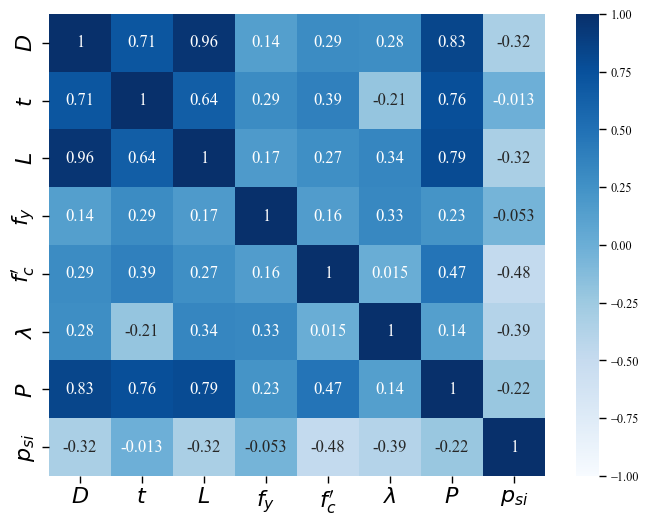

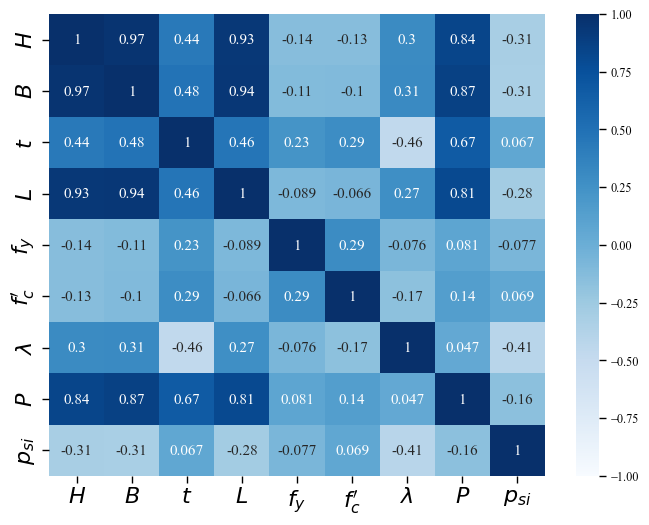

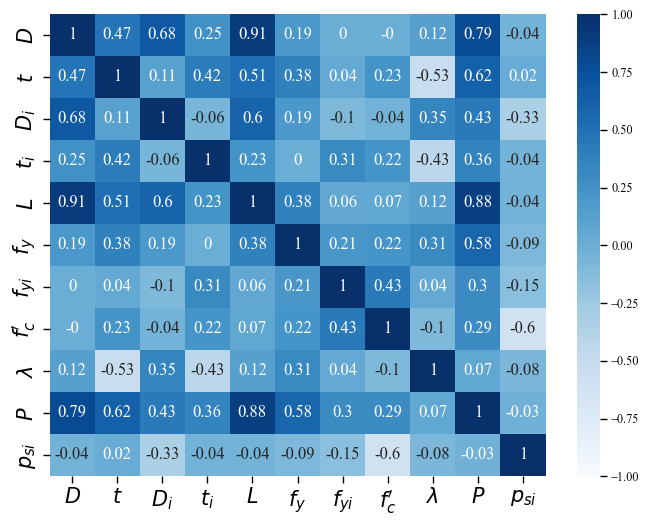

In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

PC = pd.read_excel("PC.xlsx")
pi = np.pi
PC['lam1']=PC['D']/PC['t']*PC['Fy']/208000.0
PC['P_PcS'] = PC['P'] / (((PC['D'] - PC['t']) * PC['t'] * PC['Fy']) + ((PC['D'] - 2.0 * PC['t']) ** 2.0 * PC['fc'] / 4.0)) / pi * 1000.0
PC_CIRC=PC
X1 = PC[['D', 't', 'L', 'Fy', 'fc', 'lam1', 'P', 'P_PcS']]
column_labels = ['$D$', '$t$', '$L$', '$f_y$', '$f^\\prime_c$', '$\\lambda$','$P$','$p_{si}$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_circ.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()

PC  = pd.read_excel("PR.xlsx")#['P', 'EC4', 'FE', 'ref', 'Author ', 'Year', 'L', 'H', 'B', 't', 'Fy', 'fc', 'D/B', 'L/B', 'D/t']
PC['lam1']=PC['B']/PC['t']*(PC['Fy']/208000.0)**0.5
PC['P_PcS']=PC['P']/((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))*1000.0
PC_REC=PC
X1=PC[['H', 'B', 't', 'L', 'Fy', 'fc', 'lam1', 'P', 'P_PcS']]
column_labels = ['$H$', '$B$', '$t$', '$L$', '$f_y$', '$f^\\prime_c$', '$\\lambda$','$P$','$p_{si}$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 12, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)

plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_rect.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()

PC = pd.read_excel("PDS.xlsx")
PC['lam1']=PC['Do']/PC['to']*PC['fyo']/208000.0
PC['P_PcS']=PC['P']/((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)/pi*1000.0
PC_DS=PC

X1=PC[['Do', 'to', 'Di', 'ti', 'L', 'fyo', 'fyi', 'fc', 'lam1', 'P', 'P_PcS']]
column_labels = ['$D$', '$t$', '$D_i$', '$t_i$', '$L$', '$f_y$', '$f_{yi}$','$f^\\prime_c$', '$\\lambda$','$P$','$p_{si}$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()
correlation_matrix=np.round(correlation_matrix, decimals=2)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 12, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=15);plt.yticks(fontsize=15)

plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_DS.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




 mu = 1.23 and sigma = 0.14


 mu = 6772.40 and sigma = 18463.75





`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




 mu = 1.04 and sigma = 0.08


 mu = 1.12 and sigma = 0.15



<Figure size 12000x4800 with 0 Axes>

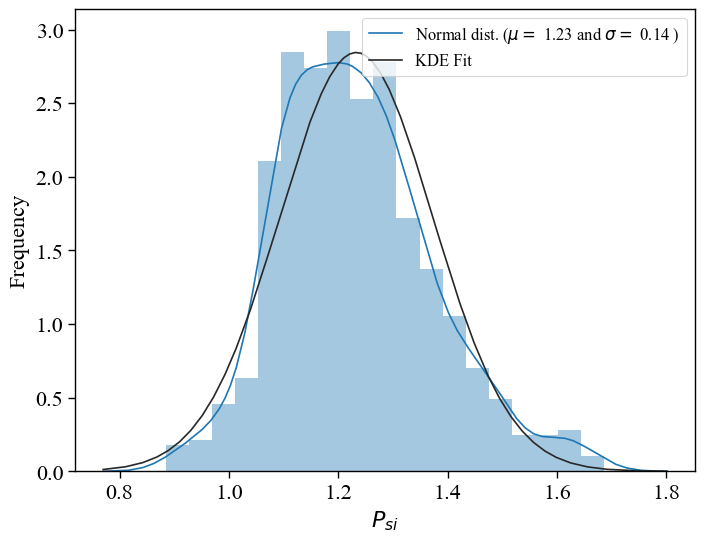

<Figure size 12000x4800 with 0 Axes>

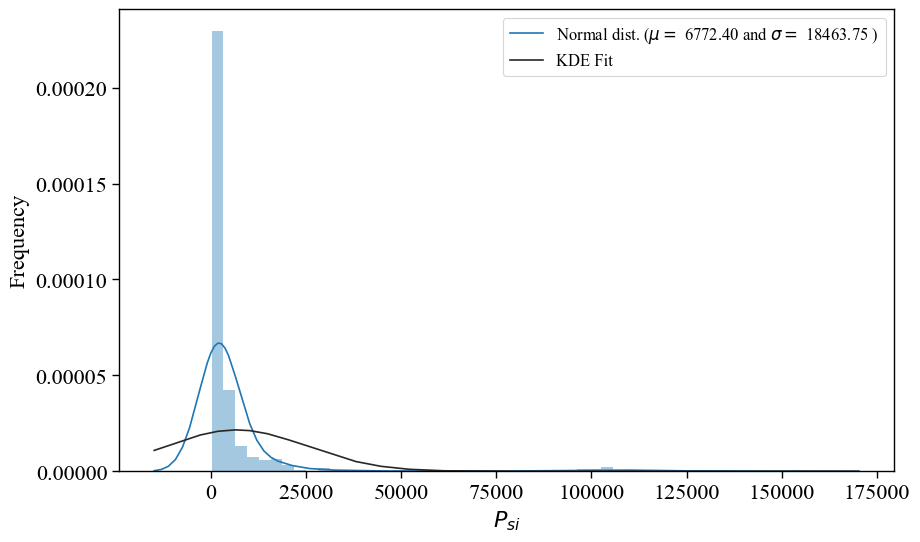

<Figure size 12000x4800 with 0 Axes>

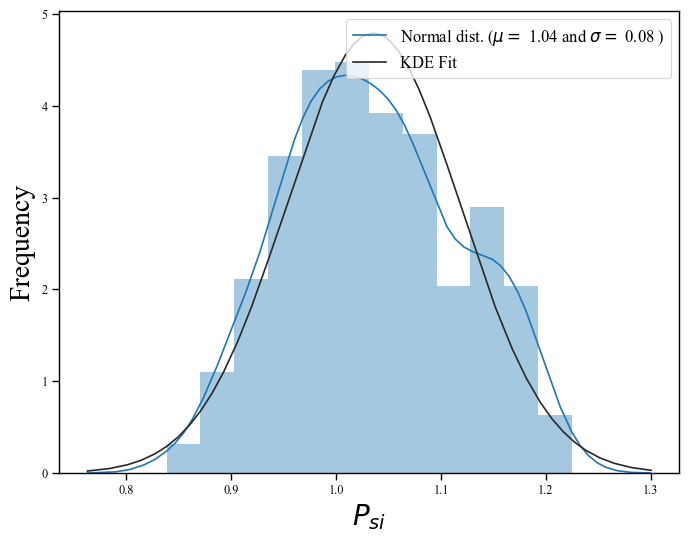

<Figure size 12000x4800 with 0 Axes>

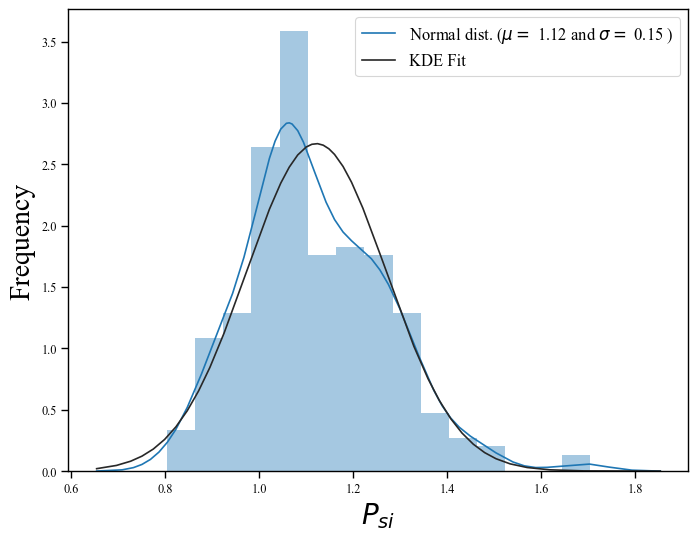

In [162]:
from scipy.stats import norm, skew
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pi = np.pi
PC=PC_CIRC

sns.set_context("paper", rc={"font.size": 20, "axes.titlesize": 20, "axes.labelsize": 20})

fig = plt.figure(dpi=600);plt.figure(figsize=(8, 6))

plt.rcParams['font.sans-serif'] = 'Times New Roman';sns.distplot(PC['P_PcS'], fit=norm)
(mu, sigma) = norm.fit(PC['P_PcS'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma),'KDE Fit'],loc='upper right', fontsize=12)
plt.ylabel('Frequency', fontsize=16);plt.xlabel("$P_{si}$", fontsize=16);plt.tick_params(axis='x', labelsize=16);plt.tick_params(axis='y', labelsize=16)
plt.savefig("Distribution_circ.png")

fig = plt.figure(dpi=600);plt.figure(figsize=(10, 6));plt.rcParams['font.sans-serif'] = 'Times New Roman';sns.distplot(PC['P'], fit=norm)
(mu, sigma) = norm.fit(PC['P'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma),'KDE Fit'],loc='upper right', fontsize=12)
plt.ylabel('Frequency', fontsize=16);plt.xlabel("$P_{si}$", fontsize=16);plt.tick_params(axis='x', labelsize=16);plt.tick_params(axis='y', labelsize=16)
plt.savefig("Distribution_circ_before.png")


PC=PC_REC
fig = plt.figure(dpi=600);plt.figure(figsize=(8, 6));plt.rcParams['font.sans-serif'] = 'Times New Roman';sns.distplot(PC['P_PcS'], fit=norm)
(mu, sigma) = norm.fit(PC['P_PcS'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma),'KDE Fit'],loc='upper right', fontsize=12)
plt.ylabel('Frequency');plt.xlabel("$P_{si}$")
plt.savefig("Distribution_rect.png")



PC=PC_DS
fig = plt.figure(dpi=600);plt.figure(figsize=(8, 6));plt.rcParams['font.sans-serif'] = 'Times New Roman';sns.distplot(PC['P_PcS'], fit=norm)
(mu, sigma) = norm.fit(PC['P_PcS'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma),'KDE Fit'],loc='upper right', fontsize=12)
plt.ylabel('Frequency');plt.xlabel("$P_{si}$")
plt.savefig("Distribution_DS.png")

SVR

In [185]:
import pso
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math
pi = math.pi
PC  = pd.read_excel("PC.xlsx")
PC['P_PcS']=PC['P']/((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)/pi*1000.0
X=PC[['D', 't', 'L', 'Fy', 'fc']]#PC.drop('P',axis=1)
y=PC['P_PcS']
X,y = np.array(X.values),np.array(y.values)
scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)
num_folds=5
def objective_function(params):
    C, epsilon, gamma = params
    mse_scores = []
    
    # Split the data into folds
    fold_size = len(X_train) // num_folds
    folds_X = np.array_split(X_train, num_folds)
    folds_y = np.array_split(y_train, num_folds)
    
    # Perform cross-validation
    for i in range(num_folds):
        # Create the SVR model
        model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
        
        # Merge the data for training and testing
        X_test_fold,X_train_fold = folds_X[i], np.concatenate(folds_X[:i] + folds_X[i+1:])
        y_test_fold,y_train_fold = folds_y[i], np.concatenate(folds_y[:i] + folds_y[i+1:])

        # Train the model and predict
        model.fit(X_train_fold, y_train_fold.reshape(-1))
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate the mean squared error
        divide = scaler_out.inverse_transform(y_pred_fold.reshape(-1, 1))/scaler_out.inverse_transform(y_test_fold.reshape(-1, 1))
        mse_fold = np.std(divide)
        
        mse_scores.append(mse_fold)
    
    # Calculate the mean of the mse scores
    mse = np.mean(mse_scores)
    return mse
lower_bound = [-3., -100.,-10.]
upper_bound = [5., -10., 20.]


# Define Optimization Problem
problem = {'CostFunction': objective_function, 'nVar': 3, 'VarMin': lower_bound, 'VarMax': upper_bound}

# Running PSO
gbest, pop = pso.PSO(problem, MaxIter = 10, PopSize = 100, c1 = 1.0, c2 = 1.0, w = 0.1, wdamp = 0.1)
# Final Result
print('Global Best:')
print(gbest)


Iteration 0: Best Cost = 0.06960562136208984
Iteration 1: Best Cost = 0.06959628638423845
Iteration 2: Best Cost = 0.06959500082252297
Iteration 3: Best Cost = 0.06959450641054618
Iteration 4: Best Cost = 0.06959393445059557
Iteration 5: Best Cost = 0.06959249564580965
Iteration 6: Best Cost = 0.06959249564580965
Iteration 7: Best Cost = 0.06959249564580965
Iteration 8: Best Cost = 0.06958790989560296
Iteration 9: Best Cost = 0.06958790989560296
Global Best:
{'position': array([  0.10616978, -73.89248489,   3.23800559]), 'cost': 0.06958790989560296}


In [186]:
score = objective_function(gbest['position'])
print(gbest['cost'])
C, epsilon, gamma = gbest['position']#0.98377012, -69.37560749,   3.35051143
#increase number of particles from 50 to 500 #0.96109455, -27.71123196,   3.36205192
#[  0.95663944, -61.30657623,   3.36564107]), 'cost': 0.06111466489637234}
model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
model.fit(X_train, y_train.reshape(-1))
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)
X1_test=np.concatenate((X_test, X_train), axis=0)
lengthy=len(y_train);print(lengthy)

y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = model.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
print(np.std(divide)/np.mean(divide))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)

df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename = 'SVR_Circ.xlsx'
df.to_excel(filename, index=False)

print("Data exported to", filename)


0.06958790989560296
0.04461740078894062
539
0.045394029192482456
Data exported to SVR_Circ.xlsx


save

rectangular

In [214]:
import pso
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math
pi = math.pi
PC  = pd.read_excel("PR.xlsx")#['P', 'EC4', 'FE', 'ref', 'Author ', 'Year', 'L', 'H', 'B', 't', 'Fy', 'fc', 'D/B', 'L/B', 'D/t']
PC['P_PcS']=PC['P']/((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))*1000.0
X=PC[['H', 'B', 't', 'L', 'Fy', 'fc']]#PC.drop('P',axis=1)
y=PC['P_PcS']
X,y = np.array(X.values),np.array(y.values)
scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=101)
num_folds=5
def objective_function(params):
    C, epsilon, gamma = params
    mse_scores = []
    
    # Split the data into folds
    fold_size = len(X_train) // num_folds
    folds_X = np.array_split(X_train, num_folds)
    folds_y = np.array_split(y_train, num_folds)
    
    # Perform cross-validation
    for i in range(num_folds):
        # Create the SVR model
        model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
        
        # Merge the data for training and testing
        X_test_fold,X_train_fold = folds_X[i], np.concatenate(folds_X[:i] + folds_X[i+1:])
        y_test_fold,y_train_fold = folds_y[i], np.concatenate(folds_y[:i] + folds_y[i+1:])

        # Train the model and predict
        model.fit(X_train_fold, y_train_fold.reshape(-1))
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate the mean squared error
        divide = scaler_out.inverse_transform(y_pred_fold.reshape(-1, 1))/scaler_out.inverse_transform(y_test_fold.reshape(-1, 1))
        mse_fold = np.std(divide)
        
        mse_scores.append(mse_fold)
    
    # Calculate the mean of the mse scores
    mse = np.mean(mse_scores)
    return mse
lower_bound = [-3., -100.,-10.]
upper_bound = [5., -10., 20.]


# Define Optimization Problem
problem = {'CostFunction': objective_function, 'nVar': 3, 'VarMin': lower_bound, 'VarMax': upper_bound}

# Running PSO
gbest, pop = pso.PSO(problem, MaxIter = 10, PopSize = 100, c1 = 1.0, c2 = 1.0, w = 0.1, wdamp = 0.1)
# Final Result
print('Global Best:')
print(gbest)


Iteration 0: Best Cost = 0.06328111435859332
Iteration 1: Best Cost = 0.06302913331992768
Iteration 2: Best Cost = 0.06302743255027174
Iteration 3: Best Cost = 0.06301642110363788
Iteration 4: Best Cost = 0.06301603423843741
Iteration 5: Best Cost = 0.06301508653638835
Iteration 6: Best Cost = 0.06301508653638835
Iteration 7: Best Cost = 0.06301508653638835
Iteration 8: Best Cost = 0.06301508653638835
Iteration 9: Best Cost = 0.06301406980273198
Global Best:
{'position': array([ -0.48873314, -48.52980348,   1.44601531]), 'cost': 0.06301406980273198}


In [215]:
score = objective_function(gbest['position'])
print(gbest['cost'])
C, epsilon, gamma = gbest['position']#-0.39317381, -82.44798443,   2.66396602       #other trial -0.38320777, -53.22999924,   2.65792762
model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
model.fit(X_train, y_train.reshape(-1))
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

X1_test=np.concatenate((X_test, X_train), axis=0)
y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = model.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
print(np.std(divide)/np.mean(divide))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)

df = pd.DataFrame(data2)
df.columns = ['H', 'B', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df

PC['P_exp']=PC['P_exp']*((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
PC['P_pred']=PC['P_pred']*((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
filename = 'SVR_rect.xlsx'
df.to_excel(filename, index=False)

print("Data exported to", filename)

0.06301406980273198
0.05522269171222805


Data exported to SVR_rect.xlsx


Skin

In [187]:
import pso
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math
pi = math.pi
PC = pd.read_excel("PDS.xlsx")
#['P', 'FE', 'nam', 'L', 'Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc', 'Do/to', 'Di/ti', 'L/Do ', 'REF_N']
PC['P_PcS']=PC['P']/((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)/pi*1000.0
X=PC[['Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc']]#PC.drop('P',axis=1)
y=PC['P_PcS']
X,y = np.array(X.values),np.array(y.values)
scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)
num_folds=5
def objective_function(params):
    C, epsilon, gamma = params
    mse_scores = []
    
    # Split the data into folds
    fold_size = len(X_train) // num_folds
    folds_X = np.array_split(X_train, num_folds)
    folds_y = np.array_split(y_train, num_folds)
    
    # Perform cross-validation
    for i in range(num_folds):
        # Create the SVR model
        model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
        
        # Merge the data for training and testing
        X_test_fold,X_train_fold = folds_X[i], np.concatenate(folds_X[:i] + folds_X[i+1:])
        y_test_fold,y_train_fold = folds_y[i], np.concatenate(folds_y[:i] + folds_y[i+1:])

        # Train the model and predict
        model.fit(X_train_fold, y_train_fold.reshape(-1))
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate the mean squared error
        divide = scaler_out.inverse_transform(y_pred_fold.reshape(-1, 1))/scaler_out.inverse_transform(y_test_fold.reshape(-1, 1))
        mse_fold = np.std(divide)
        
        mse_scores.append(mse_fold)
    
    # Calculate the mean of the mse scores
    mse = np.mean(mse_scores)
    return mse
lower_bound = [-3., -100.,-10.]
upper_bound = [5., -10., 20.]


# Define Optimization Problem
problem = {'CostFunction': objective_function, 'nVar': 3, 'VarMin': lower_bound, 'VarMax': upper_bound}

# Running PSO
gbest, pop = pso.PSO(problem, MaxIter = 10, PopSize =100, c1 = 1.0, c2 = 1.0, w = 0.1, wdamp = 0.1)
# Final Result
print('Global Best:')
print(gbest)


Iteration 0: Best Cost = 0.06733961518873625
Iteration 1: Best Cost = 0.06722976699452764
Iteration 2: Best Cost = 0.06715032097399072
Iteration 3: Best Cost = 0.06715032097399072
Iteration 4: Best Cost = 0.0671434528884762
Iteration 5: Best Cost = 0.06713984065780687
Iteration 6: Best Cost = 0.06713842657113253
Iteration 7: Best Cost = 0.06713575177056515
Iteration 8: Best Cost = 0.06713575177056515
Iteration 9: Best Cost = 0.06713575177056515
Global Best:
{'position': array([  0.47952327, -63.36560673,   1.49123179]), 'cost': 0.06713575177056515}


In [208]:
print(gbest)

{'position': array([  0.47952327, -63.36560673,   1.49123179]), 'cost': 0.06713575177056515}


In [213]:
score = objective_function(gbest['position'])
print(gbest['cost'])
C, epsilon, gamma = gbest['position']#0.96493032, -45.74909644,  -0.30629572, 'cost': 0.05310375525504531
#other trial 2.08346664, -32.89998459,  -0.5354728         cost 0.052880639637376284
#other trial 2.04979493, -44.98660463,  -0.53970678         cost 0.052875574850241004
#other trial 2.2564744 , -67.30869604,  -0.60549525         cost': 0.05286050410297427
model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
model.fit(X_train, y_train.reshape(-1))
y_pred = model.predict(X_test)
#print(mean_squared_error(y_test, y_pred))

X1_test=np.concatenate((X_test, X_train), axis=0)
y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = model.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
print(np.std(divide)/np.mean(divide))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)

df = pd.DataFrame(data2)
df.columns = ['Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)*pi/1000.0
filename = 'SVR_skin.xlsx'
df.to_excel(filename, index=False)

print("Data exported to", filename)

0.06713575177056515
0.03618238922773527
Data exported to SVR_skin.xlsx


Circular

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, WhiteKernel,RationalQuadratic,Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
pi = math.pi
PC  = pd.read_excel("PC.xlsx")
PC['P_PcS']=PC['P']/((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)/pi*1000.0
X=PC[['D', 't', 'L', 'Fy', 'fc']]
y=PC['P_PcS']
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));out_scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=out_scaler.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=42)

In [14]:
gpr = GaussianProcessRegressor(alpha=0.001)#,normalize_y=True
gpr.kernel = ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*RBF(length_scale=1.0,length_scale_bounds=(1e-5,1e5))+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*Matern(length_scale=1.0, length_scale_bounds=(1e-5,1e5), nu=1.0)+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*WhiteKernel(noise_level=0.1)+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*RationalQuadratic(length_scale=1,alpha=1)
gpr.fit(X_train, y_train.reshape(-1,1))
y_pred, y_std = gpr.predict(X_tot, return_std=True)
if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred

The optimal value found for dimension 0 of parameter k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


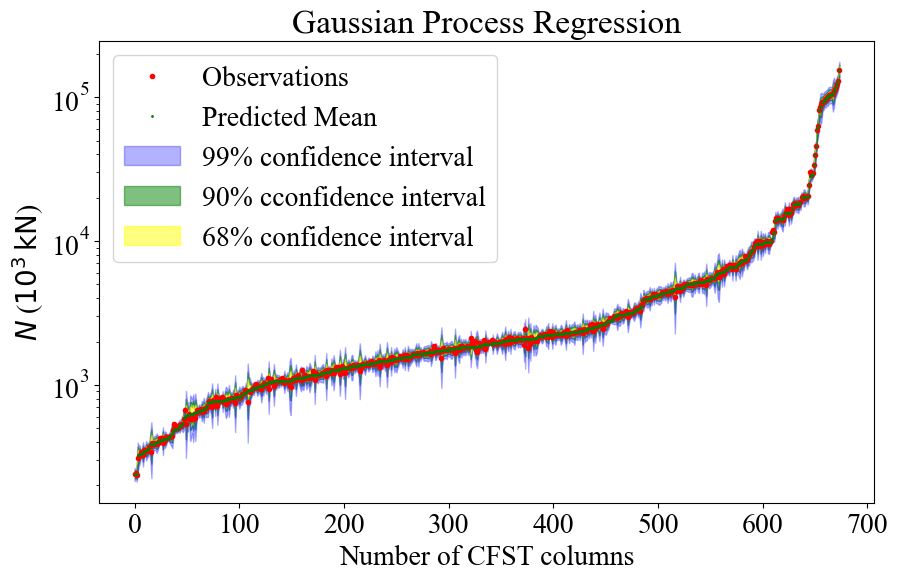

In [15]:
if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred
y_tot11=y_tot;X_tot11=X_tot;y_pred11=y_pred;y_std2=y_std
yr=y_std2.reshape(-1, 1)+y_pred.reshape(-1, 1)
data = out_scaler.inverse_transform( y_tot11.reshape(-1, 1))
data1= out_scaler.inverse_transform(y_pred11.reshape(-1, 1))
yr   = out_scaler.inverse_transform(yr.reshape(-1, 1))
y_std2=yr.reshape(-1, 1)-data.reshape(-1, 1)
X     =     scaler.inverse_transform(X_tot)

data2=np.concatenate((X,data.reshape(-1, 1),data1.reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df;PC['sd']=y_std2;#PC['sd']=np.clip(y_std2, 0, 0.3)
PC['multi']=((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_exp']=PC['P_exp']*PC['multi'];PC['P_pred']=PC['P_pred']*PC['multi'];PC['sd']=PC['sd']*PC['multi']
y_tot11=np.array(PC['P_exp'].values);y_pred11=np.array(PC['P_pred'].values);y_std2=np.array(PC['sd'].values)

filename ='Gpr_circ.xlsx'
PC.to_excel(filename, index=False)

#arrange
vv = np.vstack((X_tot11.transpose(),y_std2,y_tot11,y_pred11)).transpose()
v1 = vv[np.argsort(vv[:, -1])]
#previous sheet excel is wrong as you didnot sort x_tot
X_tot11,y_std2,y_tot11,y_pred11=v1[:,:-3],v1[:,-3],v1[:,-2],v1[:,-1]
# Calculate the upper and lower confidence bounds
#0.674
#2.576 is 99% confidence 1.96 is 95%confidence interval #1.645 is 90% #2.576 for 99% #1.0 for 68%
lower_bound99 = y_pred11.flatten() - 2.576* y_std2.flatten();upper_bound99 = y_pred11.flatten() + 2.576* y_std2.flatten()#99% confidence
lower_bound90 = y_pred11.flatten() - 1.645* y_std2.flatten();upper_bound90 = y_pred11.flatten() + 1.645* y_std2.flatten()#1.645 is 90%
lower_bound68 = y_pred11.flatten() - 1.0  * y_std2.flatten();upper_bound68 = y_pred11.flatten() + 1.0  * y_std2.flatten()#1.0 for 68%
# Plot the data, true function, and confidence intervals
plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
# Fill between the confidence bounds
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)

plt.xlabel('Number of CFST columns');plt.ylabel(r'$N$ ($10^3 \, \mathrm{kN}$)');plt.title('Gaussian Process Regression');plt.legend()
plt.savefig("GPR_Predicted_Mean_Confidence_Intervals1.png", dpi=500)
plt.show()

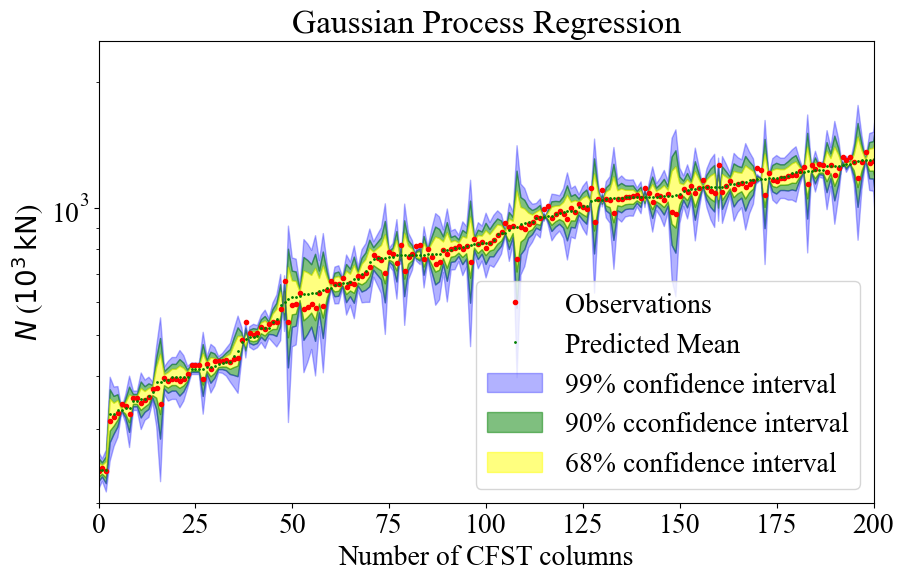

In [17]:
plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)
plt.xlabel('Number of CFST columns');plt.ylabel(r'$N$ ($10^3 \, \mathrm{kN}$)');plt.title('Gaussian Process Regression');plt.legend()
plt.ylim(200, 2500);plt.xlim(0, 200)
plt.savefig("GPR_Predicted_Mean_Confidence_Intervals2.png", dpi=500)
plt.show()

Rectangular

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, WhiteKernel,RationalQuadratic,Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
pi = math.pi
PC  = pd.read_excel("PR.xlsx")#['P', 'EC4', 'FE', 'ref', 'Author ', 'Year', 'L', 'H', 'B', 't', 'Fy', 'fc', 'D/B', 'L/B', 'D/t']
PC['P_PcS']=PC['P']/((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))*1000.0
X=PC[['H', 'B', 't', 'L', 'Fy', 'fc']];y=PC['P_PcS']
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));out_scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=out_scaler.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=101)
'''
gpr = GaussianProcessRegressor(alpha=0.001)#,normalize_y=True
gpr.kernel = ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*RBF(length_scale=1.0,length_scale_bounds=(1e-5,1e5))+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*Matern(length_scale=1.0, length_scale_bounds=(1e-5,1e5), nu=1.0)+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*WhiteKernel(noise_level=0.1)+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*RationalQuadratic(length_scale=1,alpha=1)
gpr.fit(X_train, y_train.reshape(-1,1))'''

# Define the GPR model
gpr = GaussianProcessRegressor()
gpr.kernel = (
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=1.0) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    WhiteKernel(noise_level=0.1) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RationalQuadratic(length_scale=1, alpha=1)
)

# Set up the parameter grid for alpha
alpha_values = [0.0001,0.0004,0.0005,0.0007,0.001,0.002]  # Add more values if needed

# Perform cross-validation to find the best alpha
best_alpha = None
best_score = -np.inf
for alpha in alpha_values:
    gpr.alpha = alpha
    scores = cross_val_score(gpr, X_train, y_train.reshape(-1, 1), cv=5)  # Use your desired number of folds
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha


The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k1__consta

In [200]:
print(best_alpha)

0.0004
0.0004


In [224]:
# Fit the GPR model with the best alpha
gpr.alpha = best_alpha
gpr.fit(X_train, y_train.reshape(-1, 1))

# Make predictions using the trained model
y_pred, y_std = gpr.predict(X_normalized, return_std=True)
if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred

In [226]:
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = gpr.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['H', 'B', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
PC['P_pred']=PC['P_pred']*((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
filename = 'Gpr_rect.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

Data exported to Gpr_rect.xlsx


(396, 1)
(396, 1)


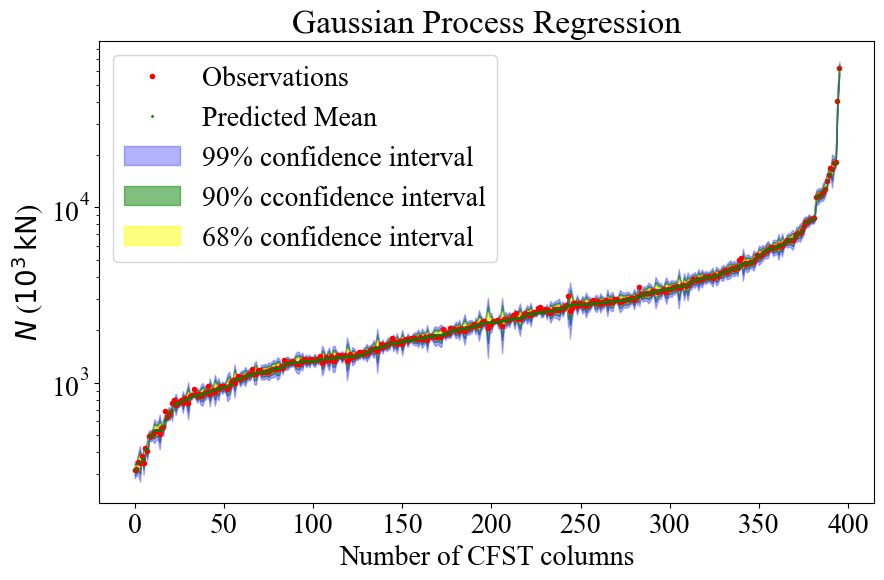

In [191]:
y_tot11=y_tot;X_tot11=X_tot;y_pred11=y_pred;y_std2=y_std
yr=y_std2.reshape(-1, 1)+y_pred.reshape(-1, 1)
data = out_scaler.inverse_transform( y_tot11.reshape(-1, 1))
data1= out_scaler.inverse_transform(y_pred11.reshape(-1, 1))
yr   = out_scaler.inverse_transform(yr.reshape(-1, 1))
print(data.shape)
print(yr.shape)
y_std2=yr-data
X     =     scaler.inverse_transform(X_tot)

data2=np.concatenate((X,data.reshape(-1, 1),data1.reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns = ['H', 'B', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df;PC['sd']=y_std2;#PC['sd']=np.clip(y_std2, 0, 0.3)
PC['multi']=((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
PC['P_exp']=PC['P_exp']*PC['multi'];PC['P_pred']=PC['P_pred']*PC['multi'];PC['sd']=PC['sd']*PC['multi']
y_tot11=np.array(PC['P_exp'].values);y_pred11=np.array(PC['P_pred'].values);y_std2=np.array(PC['sd'].values)
#arrange
vv = np.vstack((X_tot11.transpose(),y_std2,y_tot11,y_pred11)).transpose()
v1 = vv[np.argsort(vv[:, -1])]
#previous sheet excel is wrong as you didnot sort x_tot
X_tot11,y_std2,y_tot11,y_pred11=v1[:,:-3],v1[:,-3],v1[:,-2],v1[:,-1]
# Calculate the upper and lower confidence bounds
#0.674
#2.576 is 99% confidence 1.96 is 95%confidence interval #1.645 is 90% #2.576 for 99% #1.0 for 68%
lower_bound99 = y_pred11.flatten() - 2.576* y_std2.flatten();upper_bound99 = y_pred11.flatten() + 2.576* y_std2.flatten()#99% confidence
lower_bound90 = y_pred11.flatten() - 1.645* y_std2.flatten();upper_bound90 = y_pred11.flatten() + 1.645* y_std2.flatten()#1.645 is 90%
lower_bound68 = y_pred11.flatten() - 1.0  * y_std2.flatten();upper_bound68 = y_pred11.flatten() + 1.0  * y_std2.flatten()#1.0 for 68%
# Plot the data, true function, and confidence intervals
plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
# Fill between the confidence bounds
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)

plt.xlabel('Number of CFST columns');plt.ylabel(r'$N$ ($10^3 \, \mathrm{kN}$)');plt.title('Gaussian Process Regression');plt.legend()
plt.savefig("Rect_GPR_Predicted_Mean_Confidence_Intervals1.png", dpi=500)
plt.show()


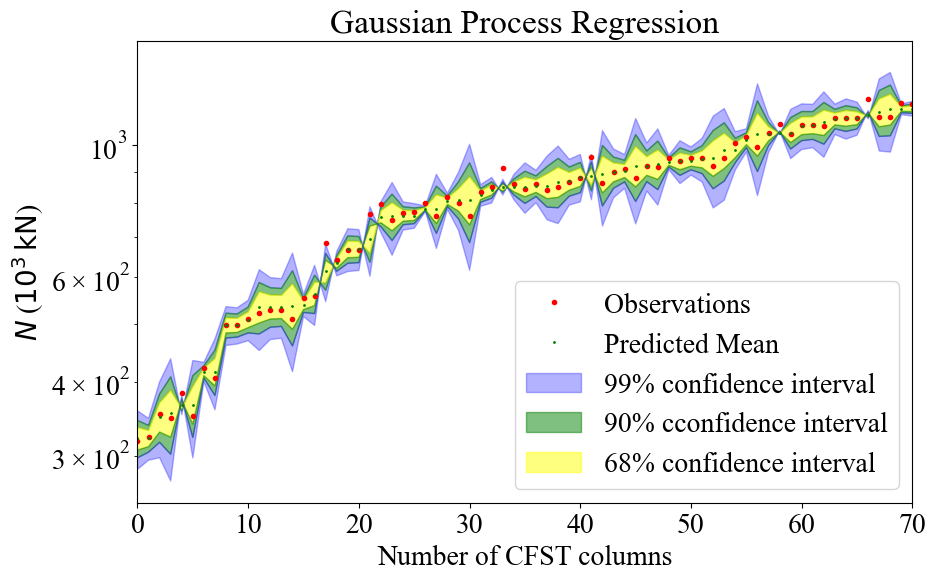

In [192]:
plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)
plt.xlabel('Number of CFST columns');plt.ylabel(r'$N$ ($10^3 \, \mathrm{kN}$)');plt.title('Gaussian Process Regression');plt.legend()
plt.ylim(250, 1500);plt.xlim(0, 70)
plt.savefig("Rect_GPR_Predicted_Mean_Confidence_Intervals2.png", dpi=500)
plt.show()


Not run

Double skin

In [193]:
PC = pd.read_excel("PDS.xlsx")
#['P', 'FE', 'nam', 'L', 'Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc', 'Do/to', 'Di/ti', 'L/Do ', 'REF_N']
PC['P_PcS']=PC['P']/((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)/pi*1000.0
X=PC[['Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc']];y=PC['P_PcS']
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));out_scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=out_scaler.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=42)
'''
gpr = GaussianProcessRegressor(alpha=0.001)#,normalize_y=True
gpr.kernel = ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*RBF(length_scale=1.0,length_scale_bounds=(1e-5,1e5))+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*Matern(length_scale=1.0, length_scale_bounds=(1e-5,1e5), nu=1.0)+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*WhiteKernel(noise_level=0.1)+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*RationalQuadratic(length_scale=1,alpha=1)
gpr.fit(X_train, y_train.reshape(-1,1))
y_pred, y_std = gpr.predict(X_tot, return_std=True)
if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred'''

# Define the GPR model
gpr = GaussianProcessRegressor()
gpr.kernel = (
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=1.0) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    WhiteKernel(noise_level=0.1) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RationalQuadratic(length_scale=1, alpha=1)
)

# Set up the parameter grid for alpha
alpha_values = [0.0001,0.0004,0.0005,0.0007,0.001,0.002]  # Add more values if needed

# Perform cross-validation to find the best alpha
best_alpha = None
best_score = -np.inf
for alpha in alpha_values:
    gpr.alpha = alpha
    scores = cross_val_score(gpr, X_train, y_train.reshape(-1, 1), cv=5)  # Use your desired number of folds
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

# Fit the GPR model with the best alpha
gpr.alpha = best_alpha
gpr.fit(X_train, y_train.reshape(-1, 1))

# Make predictions using the trained model
y_pred, y_std = gpr.predict(X_normalized, return_std=True)
if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred


The optimal value found for dimension 0 of parameter k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k2__alpha is close to 

In [195]:
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = gpr.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)*pi/1000.0
filename = 'Gpr_DS.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

Data exported to Gpr_DS.xlsx


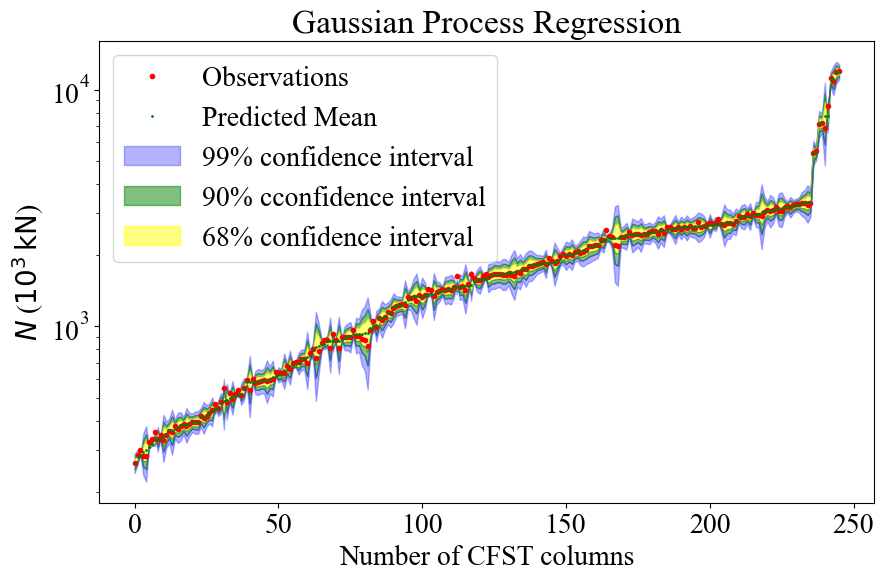

In [196]:
y_tot11=y_tot;X_tot11=X_tot;y_pred11=y_pred;y_std2=y_std
yr=y_std2.reshape(-1, 1)+y_pred.reshape(-1, 1)
data = out_scaler.inverse_transform( y_tot11.reshape(-1, 1))
data1= out_scaler.inverse_transform(y_pred11.reshape(-1, 1))
yr   = out_scaler.inverse_transform(yr.reshape(-1, 1))
y_std2=yr.reshape(-1, 1)-data.reshape(-1, 1)
X     =     scaler.inverse_transform(X_tot)

data2=np.concatenate((X,data.reshape(-1, 1),data1.reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns =['Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc','P_exp','P_pred'];PC=df;PC['sd']=y_std2;#PC['sd']=np.clip(y_std2, 0, 0.3)
PC['multi']=((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)*pi/1000.0
PC['P_exp']=PC['P_exp']*PC['multi'];PC['P_pred']=PC['P_pred']*PC['multi'];PC['sd']=PC['sd']*PC['multi']
y_tot11=np.array(PC['P_exp'].values);y_pred11=np.array(PC['P_pred'].values);y_std2=np.array(PC['sd'].values)

#arrange
vv = np.vstack((X_tot11.transpose(),y_std2,y_tot11,y_pred11)).transpose()
v1 = vv[np.argsort(vv[:, -1])]
#previous sheet excel is wrong as you didnot sort x_tot
X_tot11,y_std2,y_tot11,y_pred11=v1[:,:-3],v1[:,-3],v1[:,-2],v1[:,-1]
# Calculate the upper and lower confidence bounds
#0.674
#2.576 is 99% confidence 1.96 is 95%confidence interval #1.645 is 90% #2.576 for 99% #1.0 for 68%
lower_bound99 = y_pred11.flatten() - 2.576* y_std2.flatten();upper_bound99 = y_pred11.flatten() + 2.576* y_std2.flatten()#99% confidence
lower_bound90 = y_pred11.flatten() - 1.645* y_std2.flatten();upper_bound90 = y_pred11.flatten() + 1.645* y_std2.flatten()#1.645 is 90%
lower_bound68 = y_pred11.flatten() - 1.0  * y_std2.flatten();upper_bound68 = y_pred11.flatten() + 1.0  * y_std2.flatten()#1.0 for 68%
# Plot the data, true function, and confidence intervals
plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
# Fill between the confidence bounds
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)

plt.xlabel('Number of CFST columns');plt.ylabel(r'$N$ ($10^3 \, \mathrm{kN}$)');plt.title('Gaussian Process Regression');plt.legend()
plt.savefig("Skin_GPR_Predicted_Mean_Confidence_Intervals1.png", dpi=500)
plt.show()


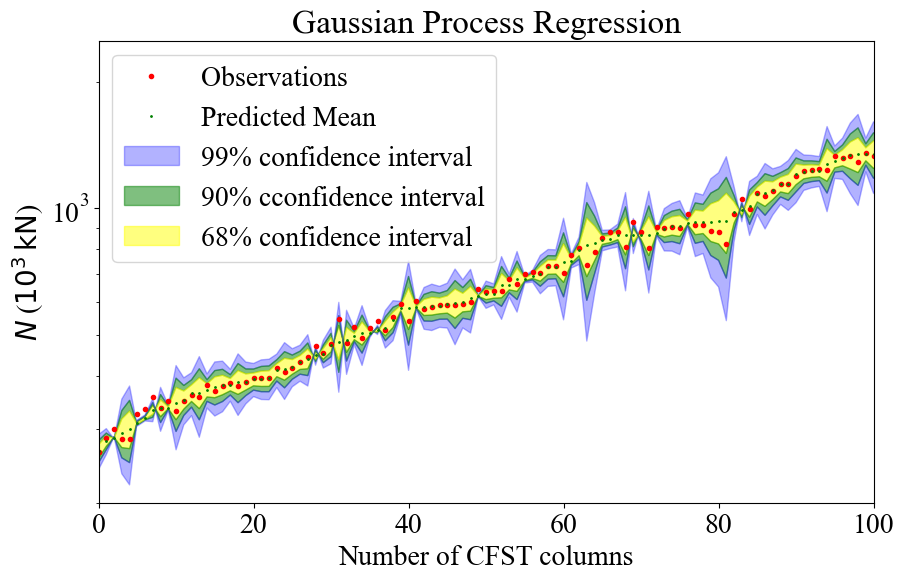

In [197]:
plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)
plt.xlabel('Number of CFST columns');plt.ylabel(r'$N$ ($10^3 \, \mathrm{kN}$)');plt.title('Gaussian Process Regression');plt.legend()
plt.ylim(200, 2500);plt.xlim(0, 100)
plt.savefig("Skin_GPR_Predicted_Mean_Confidence_Intervals2.png", dpi=500)
plt.show()


other trial

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, WhiteKernel,RationalQuadratic,Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
pi = math.pi
from sklearn.model_selection import cross_val_score

# Load the data
PC = pd.read_excel("PC.xlsx")
PC['P_PcS'] = PC['P'] / ((PC['D'] - PC['t']) * PC['t'] * PC['Fy'] + (PC['D'] - 2.0 * PC['t']) ** 2.0 * PC['fc'] / 4.0) / pi * 1000.0
X = PC[['D', 't', 'L', 'Fy', 'fc']]
y = PC['P_PcS']
X, y = np.array(X.values), np.array(y.values)

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1));out_scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = scaler.fit_transform(X);y_normalized = out_scaler.fit_transform(y.reshape(-1, 1))
X_tot=X_normalized;y_tot=y_normalized
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

# Define the GPR model
gpr = GaussianProcessRegressor()
gpr.kernel = (
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=1.0) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    WhiteKernel(noise_level=0.1) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RationalQuadratic(length_scale=1, alpha=1)
)

# Set up the parameter grid for alpha
alpha_values = [0.0005,0.0007,0.001,0.0013,0.003,0.01,0.1]  # Add more values if needed

# Perform cross-validation to find the best alpha
best_alpha = None
best_score = -np.inf
for alpha in alpha_values:
    gpr.alpha = alpha
    scores = cross_val_score(gpr, X_train, y_train.reshape(-1, 1), cv=5)  # Use your desired number of folds
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

# Fit the GPR model with the best alpha
gpr.alpha = best_alpha
gpr.fit(X_train, y_train.reshape(-1, 1))

# Make predictions using the trained model
y_pred, y_std = gpr.predict(X_normalized, return_std=True)
if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred


The optimal value found for dimension 0 of parameter k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__k2__alpha is close to the sp

In [183]:
print(best_alpha)

0.0007


In [159]:
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = gpr.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename = 'Gpr_circ.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred

Data exported to Gpr_circ.xlsx


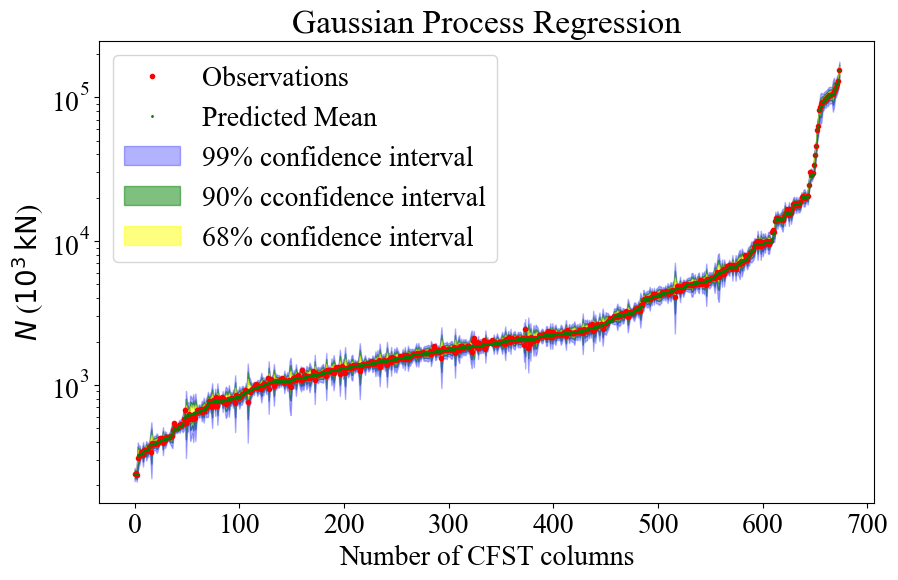

In [160]:

y_tot11=y_tot;X_tot11=X_tot;y_pred11=y_pred;y_std2=y_std
yr=y_std2.reshape(-1, 1)+y_pred.reshape(-1, 1)
data = out_scaler.inverse_transform( y_tot11.reshape(-1, 1))
data1= out_scaler.inverse_transform(y_pred11.reshape(-1, 1))
yr   = out_scaler.inverse_transform(yr.reshape(-1, 1))
y_std2=yr.reshape(-1, 1)-data.reshape(-1, 1)
X     =     scaler.inverse_transform(X_tot)

data2=np.concatenate((X,data.reshape(-1, 1),data1.reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df;PC['sd']=y_std2;#PC['sd']=np.clip(y_std2, 0, 0.3)
PC['multi']=((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_exp']=PC['P_exp']*PC['multi'];PC['P_pred']=PC['P_pred']*PC['multi'];PC['sd']=PC['sd']*PC['multi']
y_tot11=np.array(PC['P_exp'].values);y_pred11=np.array(PC['P_pred'].values);y_std2=np.array(PC['sd'].values)

#arrange
vv = np.vstack((X_tot11.transpose(),y_std2,y_tot11,y_pred11)).transpose()
v1 = vv[np.argsort(vv[:, -1])]
#previous sheet excel is wrong as you didnot sort x_tot
X_tot11,y_std2,y_tot11,y_pred11=v1[:,:-3],v1[:,-3],v1[:,-2],v1[:,-1]
# Calculate the upper and lower confidence bounds
#0.674
#2.576 is 99% confidence 1.96 is 95%confidence interval #1.645 is 90% #2.576 for 99% #1.0 for 68%
lower_bound99 = y_pred11.flatten() - 2.576* y_std2.flatten();upper_bound99 = y_pred11.flatten() + 2.576* y_std2.flatten()#99% confidence
lower_bound90 = y_pred11.flatten() - 1.645* y_std2.flatten();upper_bound90 = y_pred11.flatten() + 1.645* y_std2.flatten()#1.645 is 90%
lower_bound68 = y_pred11.flatten() - 1.0  * y_std2.flatten();upper_bound68 = y_pred11.flatten() + 1.0  * y_std2.flatten()#1.0 for 68%
# Plot the data, true function, and confidence intervals
plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
# Fill between the confidence bounds
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)

plt.xlabel('Number of CFST columns');plt.ylabel(r'$N$ ($10^3 \, \mathrm{kN}$)');plt.title('Gaussian Process Regression');plt.legend()
plt.savefig("GPR_Predicted_Mean_Confidence_Intervals1i.png", dpi=500)
plt.show()


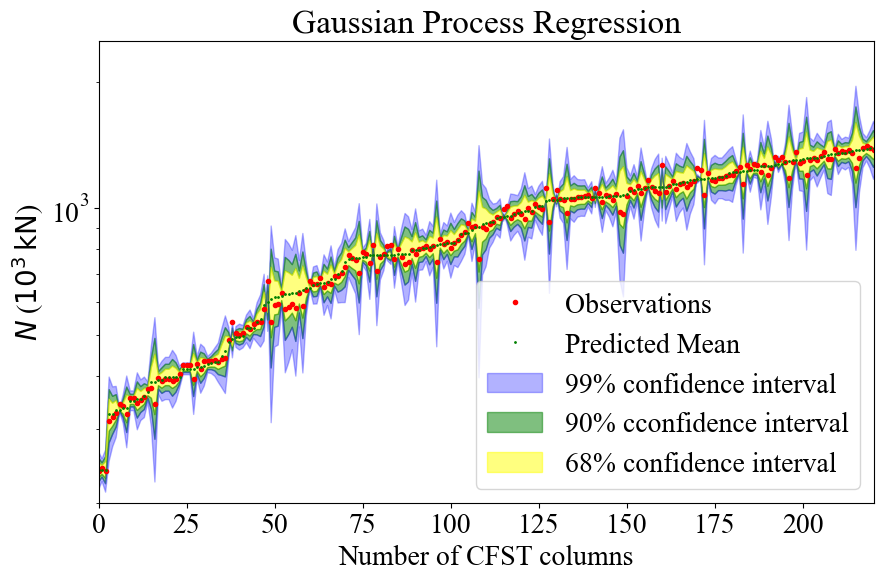

In [161]:

plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)
plt.xlabel('Number of CFST columns');plt.ylabel(r'$N$ ($10^3 \, \mathrm{kN}$)');plt.title('Gaussian Process Regression');plt.legend()
plt.ylim(200, 2500);plt.xlim(0, 220)
plt.savefig("GPR_Predicted_Mean_Confidence_Intervals1i11.png", dpi=500)
plt.show()


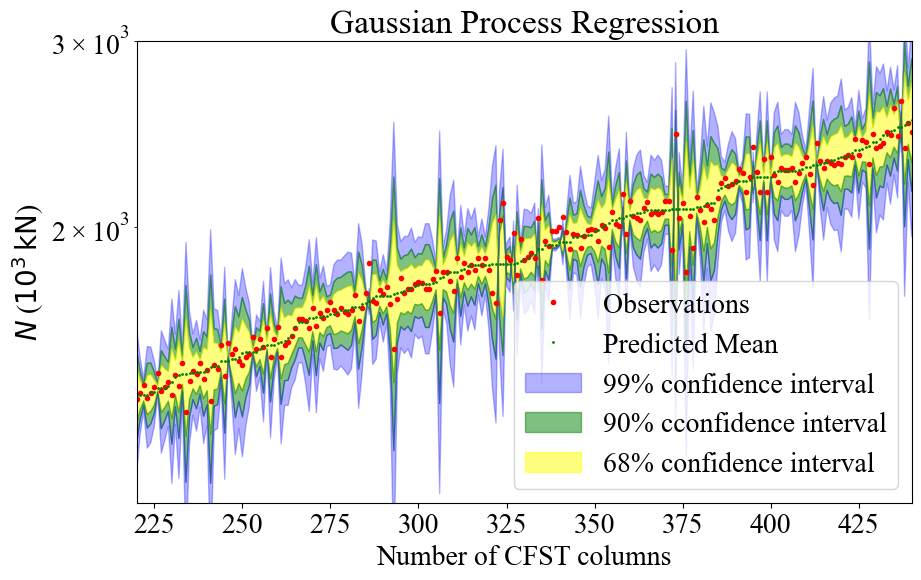

In [162]:
plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)
plt.xlabel('Number of CFST columns');plt.ylabel(r'$N$ ($10^3 \, \mathrm{kN}$)');plt.title('Gaussian Process Regression');plt.legend()
plt.ylim(1100, 3000);plt.xlim(220, 440)
plt.show()

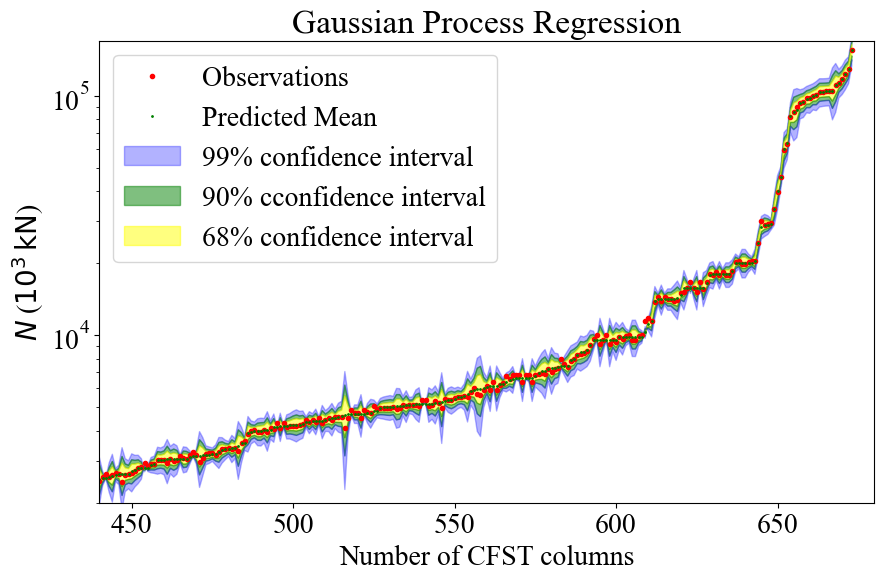

In [163]:

plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)

plt.xlabel('Number of CFST columns');plt.ylabel(r'$N$ ($10^3 \, \mathrm{kN}$)');plt.title('Gaussian Process Regression');plt.legend()
plt.ylim(2000, 170000);plt.xlim(440, 680)
plt.show()

In [266]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection._split import check_cv
from sklearn.base import is_classifier, clone
from joblib import Parallel
from sklearn.utils.fixes import delayed
from sklearn.utils.validation import _check_fit_params
from sklearn.utils.metaestimators import _safe_split
rand_stat=42
def cross_val_predict(estimator,X,y=None,*,groups=None,cv=None,n_jobs=None,verbose=0,
    fit_params=None,pre_dispatch="2*n_jobs",method="predict",XX):#XX  is added to crossfold

    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    splits = list(cv.split(X, y, groups))
    test_indices = np.concatenate([test for _, test in splits])    
    parallel = Parallel(n_jobs=n_jobs, verbose=verbose, pre_dispatch=pre_dispatch)
    ppp = parallel(
        delayed(_fit_and_predict)(clone(estimator), X, y, train, test, verbose, fit_params, method,XX=XX)
        for train, test in splits)
    
    inv_test_indices = np.empty(len(test_indices), dtype=int)
    inv_test_indices[test_indices] = np.arange(len(test_indices))
    predictions=[];y_pred_tot=[]
    for i in range(len(ppp)):
        predictions.append(ppp[i][0])
        y_pred_tot.append(ppp[i][1])                    #this line is added to crossfold
    pred = np.concatenate(predictions)
    return pred[inv_test_indices],y_pred_tot            #y_pred_tot is added to crossfold
def _fit_and_predict(estimator, X, y, train, test, verbose, fit_params, method,XX):#XX  is added to crossfold
    fit_params = fit_params if fit_params is not None else {}
    fit_params = _check_fit_params(X, fit_params, train)

    X_train, y_train = _safe_split(estimator, X, y, train)
    X_test, _ = _safe_split(estimator, X, y, test, train)

    estimator.fit(X_train, y_train, **fit_params)
    func = getattr(estimator, method)
    predictions = func(X_test)
    p_red = func(XX)                                    #this line is added to crossfold
    return predictions,p_red
nfoldy=5
feature_range=(0,7)
PC  = pd.read_excel("PC.xlsx")
PC['P_PcS']=PC['P']/((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)/pi*1000.0
X=PC[['D', 't', 'L', 'Fy', 'fc']];y=PC['P_PcS']
X,y = np.array(X.values),np.array(y.values)
scaler = MinMaxScaler(feature_range=(-1, 1));output_scaler = MinMaxScaler(feature_range=feature_range)
X_normalized = scaler.fit_transform(X);y_normalized = output_scaler.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=rand_stat)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size=0.2, random_state=rand_stat)

X_normalized=np.concatenate((X_test, X_train), axis=0);X=np.concatenate((X_test1, X_train1), axis=0);y=np.concatenate((y_test1, y_train1), axis=0)
model = MLPRegressor(hidden_layer_sizes=5, activation='logistic',max_iter=100000, solver='lbfgs', random_state=42)
kfold = KFold(n_splits=nfoldy, shuffle=True, random_state=42)
y_pred_train,p_red = cross_val_predict(model, X_train, y_train.ravel(), cv=kfold,XX=X_normalized)
y_pred_train = output_scaler.inverse_transform(y_pred_train.reshape(-1, 1))
rr=y_normalized*0.0
for i in range(nfoldy):#not found in normal fold
    rr+=np.array(p_red[i]).reshape(-1, 1)/nfoldy
y_pred_tot = output_scaler.inverse_transform(rr)


#visulaization
data1=np.concatenate((X,y.reshape(-1, 1)),axis=1)
data2=np.concatenate((data1,y_pred_tot[:,-1].reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns = ['D', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*  ((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
PC['P_pred']=PC['P_pred']*((PC['D']-PC['t'])*PC['t']*PC['Fy']+(PC['D']-2.0*PC['t'])**2.0*PC['fc']/4.0)*pi/1000.0
filename ='ML_circ.xlsx'
df.to_excel(filename, index=False)

print(np.std(data2[:,-2]/data2[:,-1]),np.mean(data2[:,-2]/data2[:,-1])) #0.06421353092185479 0.9994000056676541

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

0.06421353092185479 0.9994000056676541


In [268]:
#best solution 0.06560570163830241 0.9992537055912128 0.05652623964256681 0.9974736356353601 lbfgs tanh 3
PC  = pd.read_excel("PR.xlsx")
PC['P_PcS']=PC['P']/((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))*1000.0
X=PC[['H', 'B', 't', 'L', 'Fy', 'fc']];y=PC['P_PcS']
X,y = np.array(X.values),np.array(y.values)
scaler = MinMaxScaler(feature_range=(-1, 1));output_scaler = MinMaxScaler(feature_range=feature_range)
X_normalized = scaler.fit_transform(X);y_normalized = output_scaler.fit_transform(y.reshape(-1, 1))
rand_stat=101

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=rand_stat)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size=0.2, random_state=rand_stat)
X_normalized=np.concatenate((X_test, X_train), axis=0);X=np.concatenate((X_test1, X_train1), axis=0);y=np.concatenate((y_test1, y_train1), axis=0)

model = MLPRegressor(hidden_layer_sizes=3, activation='tanh',max_iter=100000, solver='lbfgs', random_state=42)
kfold = KFold(n_splits=nfoldy, shuffle=True, random_state=42)
y_pred_train,p_red = cross_val_predict(model, X_train, y_train.ravel(), cv=kfold,XX=X_normalized)
y_pred_train = output_scaler.inverse_transform(y_pred_train.reshape(-1, 1))
rr=y_normalized*0.0
for i in range(nfoldy):#not found in normal fold
    rr+=np.array(p_red[i]).reshape(-1, 1)/nfoldy
y_pred_tot = output_scaler.inverse_transform(rr)


#visulaization
data1=np.concatenate((X,y.reshape(-1, 1)),axis=1)
data2=np.concatenate((data1,y_pred_tot[:,-1].reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns = ['H', 'B', 't', 'L', 'Fy', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*  ((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
PC['P_pred']=PC['P_pred']*((PC['H']*PC['B'])*PC['Fy']+(PC['H']-2.0*PC['t'])*(PC['B']-2.0*PC['t'])*(PC['fc']-PC['Fy']))/1000.0
filename ='ML_Rec.xlsx'
df.to_excel(filename, index=False)

print(np.std(data2[:,-2]/data2[:,-1]),np.mean(data2[:,-2]/data2[:,-1]))#0.062416887383140836 1.0004576130378213

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

0.062416887383140836 1.0004576130378213


In [270]:
#best solution 0.06985047990854475 1.0057221088471355 0.04782906183546729 0.9994264531676212 lbfgs logistic 3
PC = pd.read_excel("PDS.xlsx")      #['P', 'FE', 'nam', 'L', 'Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc', 'Do/to', 'Di/ti', 'L/Do ', 'REF_N']
PC['P_PcS']=PC['P']/((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)/pi*1000.0
X=PC[['Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc']];y=PC['P_PcS']
X,y = np.array(X.values),np.array(y.values)
scaler = MinMaxScaler(feature_range=(-1, 1));output_scaler = MinMaxScaler(feature_range=feature_range)
rand_stat=42
X_normalized = scaler.fit_transform(X);y_normalized = output_scaler.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=rand_stat)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size=0.2, random_state=rand_stat)
X_normalized=np.concatenate((X_test, X_train), axis=0);X=np.concatenate((X_test1, X_train1), axis=0);y=np.concatenate((y_test1, y_train1), axis=0)

model = MLPRegressor(hidden_layer_sizes=3, activation='logistic',max_iter=100000, solver='lbfgs', random_state=42)
kfold = KFold(n_splits=nfoldy, shuffle=True, random_state=42)
y_pred_train,p_red = cross_val_predict(model, X_train, y_train.ravel(), cv=kfold,XX=X_normalized)
y_pred_train = output_scaler.inverse_transform(y_pred_train.reshape(-1, 1))
rr=y_normalized*0.0
for i in range(nfoldy):#not found in normal fold
    rr+=np.array(p_red[i]).reshape(-1, 1)/nfoldy
y_pred_tot = output_scaler.inverse_transform(rr)

#visulaization
data1=np.concatenate((X,y.reshape(-1, 1)),axis=1)
data2=np.concatenate((data1,y_pred_tot[:,-1].reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns = ['Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc','P_exp','P_pred'];PC=df
PC['P_exp']=PC['P_exp']*pi/1000.0*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)
PC['P_pred']=PC['P_pred']*pi/1000.0*((PC['Do']-PC['to'])*PC['to']*PC['fyo']+(PC['Di']-PC['ti'])*PC['ti']*PC['fyi']+((PC['Do']-2.0*PC['to'])**2.0-(PC['Di']-2.0*PC['ti'])**2.0)*PC['fc']/4.0)
filename ='ML_Skin.xlsx'
df.to_excel(filename, index=False)
print(np.std(data2[:,-2]/data2[:,-1]),np.mean(data2[:,-2]/data2[:,-1]))#0.05336941679326031 1.003336153765395

Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.


Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible 

0.053369416793260314 1.003336153765395


In [ ]:
#circular
rand_stat=42
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
PC  = pd.read_excel("PC.xlsx")
X_normalized = PC[['D', 't', 'L', 'Fy', 'fc']]
y_normalized = PC['P']
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=rand_stat)
Xc=np.concatenate((X_test, X_train), axis=0)
yc=np.concatenate((y_test, y_train), axis=0)


# EN1994 (2004)
def calculate_N_EC(D,t,L,f_y,f_c):
    E_s = 200000;E_c = 4400*f_c**0.50
    A_s = (D-t)*t*pi  # Cross-sectional area of steel (in mm^2)
    A_c = (D-2.0*t)**2.0/4.0*pi  # Cross-sectional area of concrete (in mm^2)
    I_s=(D)**4.0/64.0*pi-(D-2.0*t)**4.0/64.0*pi;I_c =(D-2.0*t)**4.0/64.0*pi
    N_pl = f_y * A_s + 0.85 * f_c * A_c
    N_cr = (math.pi ** 2 * (E_s * I_s + 0.6 * E_c * I_c)) / L ** 2
    lambda_val =min(0.5, math.sqrt(N_pl / N_cr))
    eta_a = min(0.25 * (3 + 2 * lambda_val), 1.0)
    eta_c = max(4.9 - 18.5 * lambda_val + 17 * lambda_val ** 2, 0)
    N_EC = eta_a * f_y * A_s + (1 + eta_c * t / D * f_y / f_c) * f_c * A_c
    return N_EC/1000.0,N_EC/(f_y * A_s + f_c * A_c)

# AISC 360 (2016)
def calculate_N_AISC(D,t,L,f_y,f_c):
    E_s = 200000;E_c = 4400*f_c**0.50
    A_s = (D-t)*t*pi  # Cross-sectional area of steel (in mm^2)
    A_c = (D-2.0*t)**2.0/4.0*pi  # Cross-sectional area of concrete (in mm^2)
    N_pl = f_y * A_s + 0.95 * f_c * A_c
    N_y = f_y * A_s + 0.7 * f_c * A_c
    lambda_p = 0.15*E_s / f_y
    lambda_r = 0.19*E_s / f_y
    lambda_val = D / t
    if lambda_val < lambda_p:
        N_AISC = N_pl
    elif lambda_p < lambda_val < lambda_r:
        N_AISC = N_pl - (N_pl - N_y) * ((lambda_val - lambda_p) / (lambda_r - lambda_p)) ** 2
    else:
        N_AISC = 0.72*f_y* A_s/(D/t/E_s*f_y)**0.2 + 0.7 * f_c * A_c       #(9 * E_s * A_s) / lambda_val ** 2
    return N_AISC/1000.0,N_AISC/(f_y * A_s + f_c * A_c)

# Test the functions
N_EC=np.zeros_like(yc);N_AISC=np.zeros_like(yc);Prop1=np.zeros_like(yc);N_EC1=np.zeros_like(yc);N_AISC1=np.zeros_like(yc);Prop1=np.zeros_like(yc);yc1=np.zeros_like(yc)
yc1ii=np.zeros_like(yc)
PC1 = pd.read_excel("SR_circ.xlsx");Prop = PC1['P_pred']
for i in range(len(yc)):
    D,t,L,f_y,f_c=Xc[i,:]
    N_EC[i],N_EC1[i] = calculate_N_EC(D,t,L,f_y,f_c)
    N_AISC[i],N_AISC1[i] = calculate_N_AISC(D,t,L,f_y,f_c)
    A_c = (D-2.0*t)**2.0/4.0*pi;        A_s = (D-t)*t*pi
    Prop1[i] = Prop[i]/(f_y * A_s + f_c * A_c)*1000.0
    yc1[i] = yc[i]/(f_y * A_s + f_c * A_c)*1000.0
    yc1ii[i] = yc1[i]/Prop1[i]
print(len(Prop1),len(Prop),len(N_AISC))
# Print the results
print("EN1994 (2004): N^EC =", np.mean(N_EC1),np.std(N_EC1)/np.mean(N_EC1))
print("AISC 360 (2016): N^AISC =", np.mean(N_AISC1),np.std(N_AISC1)/np.mean(N_AISC1))
print("Prop eqn: N^Prop =", np.mean(Prop1),np.std(Prop1)/np.mean(Prop1))
print("Prop eqn11: N^Prop =", np.mean(yc1ii),np.std(yc1ii)/np.mean(yc1ii))

PC['P_exp']=yc;PC['P_pred']=N_EC;filename = 'EC4_Circ.xlsx'
PC.to_excel(filename, index=False)
PC['P_exp']=yc;PC['P_pred']=N_AISC;filename = 'AISC_Circ.xlsx'
PC.to_excel(filename, index=False)


In [ ]:
#rect
rand_stat=101
PC  = pd.read_excel("PR.xlsx")
X_normalized = PC[['H', 'B', 't', 'L', 'Fy', 'fc']]
y_normalized = PC['P']
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=rand_stat)
Xc=np.concatenate((X_test, X_train), axis=0)
yc=np.concatenate((y_test, y_train), axis=0)

# EN1994 (2004)
def calculate_N_EC(H,B,t,L,f_y,f_c):
    A_c=(H-2.0*t)*(B-2.0*t)
    A_s=H*B-A_c
    N_EC = f_y * A_s + f_c * A_c
    return N_EC/1000.0,N_EC/(f_y * A_s + f_c * A_c)

# AISC 360 (2016)
def calculate_N_AISC(H,B,t,L,f_y,f_c):
    E_s = 200000
    A_c=(H-2.0*t)*(B-2.0*t)
    A_s=H*B-A_c
    N_pl = f_y * A_s + 0.85 * f_c * A_c
    N_y = f_y * A_s + 0.7 * f_c * A_c
    lambda_p = 2.26 * math.sqrt(E_s / f_y)
    lambda_r = 3.0 * math.sqrt(E_s / f_y)
    lambda_val = (B - 2 * t) / t
    if lambda_val < lambda_p:
        N_AISC = N_pl
    elif lambda_p < lambda_val < lambda_r:
        N_AISC = N_pl - (N_pl-N_y) * ((lambda_val - lambda_p) / (lambda_r - lambda_p)) ** 2
    else:
        N_AISC = (9 * E_s * A_s) / lambda_val ** 2 + 0.7 * f_c * A_c
    return N_AISC/1000.0,N_AISC/(f_y * A_s + f_c * A_c)
# Test the functions
N_EC=np.zeros_like(yc);N_AISC=np.zeros_like(yc);Prop1=np.zeros_like(yc);N_EC1=np.zeros_like(yc);N_AISC1=np.zeros_like(yc);Prop1=np.zeros_like(yc);yc1=np.zeros_like(yc)
yc1ii=np.zeros_like(yc)
PC1 = pd.read_excel("SR_Rect.xlsx");Prop = PC1['P_pred']
for i in range(len(yc)):
    H,B,t,L,f_y,f_c=Xc[i,:]
    N_EC[i],N_EC1[i] = calculate_N_EC(H,B,t,L,f_y,f_c)
    N_AISC[i],N_AISC1[i] = calculate_N_AISC(H,B,t,L,f_y,f_c)
    A_c=(H-2.0*t)*(B-2.0*t);        A_s = H*B-A_c
    Prop1[i] = Prop[i]/(f_y * A_s + f_c * A_c)*1000.0
    yc1[i] = yc[i]/(f_y * A_s + f_c * A_c)*1000.0
    yc1ii[i] = yc1[i]/Prop1[i]
print(len(Prop1),len(Prop),len(N_AISC))
# Print the results
print("EN1994 (2004): N^EC =", np.mean(N_EC1),np.std(N_EC1)/np.mean(N_EC1))
print("AISC 360 (2016): N^AISC =", np.mean(N_AISC1),np.std(N_AISC1)/np.mean(N_AISC1))
print("Prop eqn: N^Prop =", np.mean(Prop1),np.std(Prop1)/np.mean(Prop1))
print("Prop eqn11: N^Prop =", np.mean(yc1ii),np.std(yc1ii)/np.mean(yc1ii))

PC['P_exp']=yc;PC['P_pred']=N_EC;filename = 'EC4_Rect.xlsx'
PC.to_excel(filename, index=False)
PC['P_exp']=yc;PC['P_pred']=N_AISC;filename = 'AISC_Rect.xlsx'
PC.to_excel(filename, index=False)


In [ ]:
#skin
rand_stat=42
PC = pd.read_excel("PDS.xlsx")
X_normalized = PC[['L','Do', 'to', 'Di', 'ti', 'fyo', 'fyi', 'fc']]
y_normalized = PC['P']
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=rand_stat)
Xc=np.concatenate((X_test, X_train), axis=0)
yc=np.concatenate((y_test, y_train), axis=0)

# EN1994 (2004)
def calculate_N_EC(L,Do,to,Di,ti,f_y,f_yi,f_c):
    E_s = 200000;E_c = 4400*f_c**0.50
    A_s = (Do-to)*to*pi
    A_si = (Di-ti)*ti*pi
    A_c = ((Do-2.0*to)**2.0-(Di)**2.0)*pi/4.0
    I_c = ((Do-2.0*to)**4.0-(Di)**4.0)*pi/64.0
    I_s = (Do**4.0-(Do-2.0*to)**4.0)*pi/64.0
    I_si= (Di**4.0-(Di-2.0*ti)**4.0)*pi/64.0
    N_pl = f_y * A_s + f_yi * A_si + 0.85 * f_c * A_c
    N_cr = (math.pi ** 2 * (E_s * (I_s + I_si) + 0.6 * E_c * I_c)) / L ** 2
    lambda_val = min(0.5,math.sqrt(N_pl / N_cr))
    #print(lambda_val)
    eta_a = min(0.25 * (3 + 2 * lambda_val), 1.0)
    eta_c = max(4.9 - 18.5 * lambda_val + 17 * lambda_val ** 2, 0)
    N_EC = eta_a * (f_y * A_s) + f_yi * A_si + (1 + eta_c * to / Do * f_y / f_c) * f_c * A_c
    return N_EC/1000.0,N_EC/(f_y * A_s + f_yi * A_si + f_c * A_c)

# AISC 360 (2016)
def calculate_N_AISC(L,Do,to,Di,ti,f_y,f_yi,f_c):
    E_s = 200000
    A_s = (Do-to)*to*pi
    A_si = (Di-ti)*ti*pi
    A_c = ((Do-2.0*to)**2.0-Di**2.0)*pi/4.0
    N_pl = f_y * A_s + f_yi * A_si + 0.85 * f_c * A_c
    lambda_p = 2.26 * math.sqrt(E_s / f_y)
    lambda_r = 3.0 * math.sqrt(E_s / f_y)
    lambda_val = Do / to
    if lambda_val < lambda_p:
        N_AISC = N_pl
    elif lambda_p < lambda_val < lambda_r:
        N_AISC = N_pl - (0.25 * f_c * A_c) * ((lambda_val - lambda_p) / (lambda_r - lambda_p)) ** 2
    else:
        N_AISC = 0.72 * f_y * A_s / (lambda_val * f_y / E_s) ** 0.2 + f_yi * A_si + 0.7 * f_c * A_c
    return N_AISC/1000.0,N_AISC/(f_y * A_s + f_yi * A_si + f_c * A_c)

# Test the functions
N_EC=np.zeros_like(yc);N_AISC=np.zeros_like(yc);Prop1=np.zeros_like(yc);N_EC1=np.zeros_like(yc);N_AISC1=np.zeros_like(yc);Prop1=np.zeros_like(yc);yc1=np.zeros_like(yc)
yc1ii=np.zeros_like(yc)
PC1 = pd.read_excel("SR_DS.xlsx");Prop = PC1['P_pred']
for i in range(len(yc)):
    L,Do,to,Di,ti,f_y,f_yi,f_c=Xc[i,:]
    N_EC[i],N_EC1[i] = calculate_N_EC(L,Do,to,Di,ti,f_y,f_yi,f_c)
    N_AISC[i],N_AISC1[i] = calculate_N_AISC(L,Do,to,Di,ti,f_y,f_yi,f_c)
    A_s = (Do-to)*to*pi
    A_si = (Di-ti)*ti*pi
    A_c = ((Do-2.0*to)**2.0-(Di)**2.0)*pi/4.0
    Prop1[i] = Prop[i]/(f_y * A_s + f_yi * A_si + f_c * A_c)*1000.0
    yc1[i] = yc[i]/(f_y * A_s + f_yi * A_si + f_c * A_c)*1000.0
    yc1ii[i] = yc1[i]/Prop1[i]
print(len(Prop1),len(Prop),len(N_AISC))
# Print the results
print("EN1994 (2004): N^EC =", np.mean(N_EC1),np.std(N_EC1)/np.mean(N_EC1))
print("AISC 360 (2016): N^AISC =", np.mean(N_AISC1),np.std(N_AISC1)/np.mean(N_AISC1))
print("Prop eqn: N^Prop =", np.mean(Prop1),np.std(Prop1)/np.mean(Prop1))
print("Prop eqn11: N^Prop =", np.mean(yc1ii),np.std(yc1ii)/np.mean(yc1ii))

PC['P_exp']=yc;PC['P_pred']=N_EC;filename = 'EC4_DS.xlsx'
PC.to_excel(filename, index=False)
PC['P_exp']=yc;PC['P_pred']=N_AISC;filename = 'AISC_DS.xlsx'
PC.to_excel(filename, index=False)
